In [4]:
# This code is a copy from the recog_features.py but to deal with the output filtered
# brain data using Kalman filtering generated by Alex.

'''
The "input" of this code is 
    regressor file: recog_reg 
        which looks like three colum regressors that are used in FEAT, each object (ABCD) has a seperate regressor file?
    raw brain data: 

    where is the behavior data? at what time is each image presented? That would be the regressor file
'''

import pandas as pd
import nibabel as nib
from glob import glob
import os
from subprocess import call
import sys
import numpy as np    
import time
# sys.path.append('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten')
import ray
from pykalman import KalmanFilter
from tqdm import tqdm

ray.init(ignore_reinit_error=True)
@ray.remote(num_cpus = 0.5)
def kalman_filter_voxel(measurement):
    kf = KalmanFilter(n_dim_state = measurement.shape[1], n_dim_obs = measurement.shape[1], 
                          observation_matrices = np.eye(measurement.shape[1]),
                          observation_covariance = np.eye(measurement.shape[1]),
                          observation_offsets = np.zeros(measurement.shape[1]))
    kf = kf.em(measurement, n_iter=5,
                  em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
                  )
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurement)
    return filtered_state_means.reshape(-1)
    
def filtering(timeseries=None, filterType='highPassRealTime'): 
    '''
    filterType can be 
        highPassRealTime 
        highPassBetweenRuns 
        UnscentedKalmanFilter_filter # documentation: https://pykalman.github.io/
        UnscentedKalmanFilter_smooth
        KalmanFilter_filter
        KalmanFilter_smooth
        noFilter
    '''
    timeseries=timeseries.astype(np.float)
    oldShape=timeseries.shape
    timeseries=timeseries.reshape(timeseries.shape[0],-1)
    if filterType == 'highPassRealTime':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassRealTime(A_matrix, TR, cutoff):
            full_matrix = np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), True))
            return full_matrix[-1, :]

        filtered_timeseries=[]
        for currTR in range(timeseries.shape[0]):
            filtered_timeseries.append(highPassRealTime(timeseries[:(currTR+1)],1.5,56))
        filtered_timeseries = np.asarray(filtered_timeseries)
    elif filterType == 'highPassBetweenRuns':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassBetweenRuns(A_matrix, TR, cutoff):
            return np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), False))

        filtered_timeseries = highPassBetweenRuns(timeseries,1.5,56)
    elif filterType == 'KalmanFilter_filter_analyze_voxel_by_voxel':
        filtered_timeseries=np.zeros(timeseries.shape)
        print("time series shape", timeseries.shape)
        futures = []
        for curr_voxel in range(timeseries.shape[1]):
            measurements = np.asarray(timeseries[:,curr_voxel].reshape(-1, 1)) 
            futures.append(kalman_filter_voxel.remote(measurements))
        results = ray.get(futures)
        filtered_timeseries = np.array(results).T # transpose because results are organized by [voxel, time] 
        print("filtered_timeseries=", filtered_timeseries)
    # elif filterType == 'UnscentedKalmanFilter_filter' :
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (filtered_timeseries_state_means, filtered_timeseries_state_covariances) = ukf.filter(timeseries[:,curr_voxel])
    #         filtered_timeseries[:,curr_voxel] = filtered_timeseries_state_means.reshape(-1)
    # elif filterType == 'UnscentedKalmanFilter_smooth':
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (smoothed_state_means, smoothed_state_covariances) = ukf.smooth(data)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter_analyze_all_voxels': # KALMAN FILTER ALL VOXELS NOT WORKING
    #     print('oldShape=',oldShape)
    #     kf = KalmanFilter(n_dim_state = oldShape[1], n_dim_obs = oldShape[1], 
    #                       observation_matrices = np.eye(oldShape[1]),
    #                       observation_covariance = np.eye(oldShape[1]),
    #                       observation_offsets = np.zeros(oldShape[1]))
    #     print("time series shape", timeseries.shape)
    #     kf = kf.em(timeseries, run, n_iter=5,
    #               em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
    #                         'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    #               )
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #     filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #         filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(n_dim_obs = timeseries.shape[1], n_dim_state = timeseries.shape[1], 
    #                           observation_matrices = sparse.eye(timeseries.shape[1]), 
    #                           observation_offsets = np.zeros(timeseries.shape[1]),
    #                           observation_covariance = sparse.eye(timeseries.shape[1]))
    #     kf = kf.em(timeseries, run, n_iter=10)
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(timeseries)
    #     filtered_timeseries = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_smooth':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    elif filterType == 'noFilter':
        filtered_timeseries = timeseries
    else:
        raise Exception('filterType wrong')

    filtered_timeseries=filtered_timeseries.reshape(oldShape)
    return filtered_timeseries


def recog_features(subject='0110171',filterType = 'highPassBetweenRuns',tag=''):

    os.chdir('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/')
    subject = subject.split('_')[0]
    proj_dir = '/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/'
    dat_type = 'recog'
    data_dir = os.path.abspath(os.path.join(proj_dir,'features')) # this is the output folder where output features are saved

    # INPUT: brain data
    feature_dir = os.path.abspath(os.path.join(data_dir, filterType)) #This is the output folder, where the output features are saved
    if not os.path.isdir(feature_dir):
        os.mkdir(feature_dir)
    filt_func = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/data/nifti/realtime_preprocessed',
        '{}_neurosketch_recognition_run_{}.nii.gz')) # input, the continuous time series, brain data.
    recog_reg = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/regressor/run_{}/{}.txt')) # this is regressor file

    roi_dir = os.path.abspath(os.path.join(proj_dir,'subjects/{}_neurosketch/analysis/firstlevel/rois'))

    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/surfroi/0110171_neurosketch_V1.nii.gz    88*128*128
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_anat_mprage_brain.nii.gz.   256*256*176
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_run_1.nii.gz 94*94*72 #note V1_func_run_{1~6}.nii.gz are the same
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_recognition_run_1.nii.gz 94*94*72

    out_dir = os.path.abspath(os.path.join(feature_dir, 'recognition',tag)) 
    call(f"mkdir -p {out_dir}",shell=True)
    # if not os.path.isdir(out_dir):
        # os.mkdir(out_dir)

    objects = ['bed', 'bench', 'chair', 'table']
    roi_list_masks = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1', 'V2','LOC_FS','IT_FS','fusiform_FS','parahippo_FS','PRC_FS','ento_FS','hipp_FS','V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']
    roi_list_names = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp', 'V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']

    for curr_phase,phase in enumerate(['12', '34', '56']):
        # initialize data columns
        subj = [subject] * 160
        label = []
        run_num = [phase[0]]*80 + [phase[1]]*80
        TR_num = []
        for roi, roiname in zip(roi_list_masks, roi_list_names):
            for rn, run in enumerate(phase): # phase is '12' or '34' or '56'
                print('creating features for run {}'.format(run))

                # load subject's time series for this run
                # timeseries = nib.load(filt_func.format(subject, subject, run))
                # timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
                
                # A=time.time()
                # timeseries = filtering(timeseries=timeseries, filterType=filterType)
                # B=time.time()
                # print('timeseries.shape=',timeseries.shape)
                # print(f'filtering time passed={B-A} s for run {run} ')

                
                if tag=='':
                    timeseries = np.load(f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/filtered_timeSeries/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition1':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy") #condition1
                elif tag=='condition2':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                        
                # use information in regressor/run_x folder to make hasImage vector
                # associated TR is just the hasImage index, converted to a float
                Onsets = [0]*240
                for obj in objects:
                    with open(recog_reg.format(subject, run, obj)) as f:
                        times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                        for t in times:
                            TR = int(float(t)/1.5)
                            Onsets[TR] = obj

                # wherever hasImage, we want the features, aka only keep the features when there 
                # is an image shown
                features = [timeseries[n+3] for n, onset in enumerate(Onsets) if onset != 0] # move the timeseries by 3TRs, only keep the features when an image is shown
                labels = [label for label in Onsets if label != 0]
                FEATURES = np.array(features) if rn == 0 else np.vstack((FEATURES, np.array(features)))
                LABELS = labels if rn == 0 else LABELS + labels
            np.save('{}/{}_{}_{}_featurematrix.npy'.format(out_dir, subject, roiname, phase), FEATURES)
        
            ## metadata
            x = pd.DataFrame([subj, LABELS, run_num, TR_num]) # lists of the same length
            x = x.transpose()
            x.columns = ['subj','label','run_num', 'TR_num']
            x.to_csv('{}/metadata_{}_{}_{}.csv'.format(out_dir, subject, roiname, phase))

            # if curr_phase==0:
            #     FEATURES_oldShape=FEATURES.shape
            # else:
            #     assert np.allclose(FEATURES.shape,FEATURES_oldShape),"FEATURES shape not match"

        np.save('{}/{}_{}_featurematrix.npy'.format(out_dir, subject, phase), FEATURES)
        
#         for roi, roiname in zip(roi_list_masks, roi_list_names):
#             # mask = nib.load('{}/{}.nii.gz'.format(roi_dir.format(subject), roi))
#             # mask = nib.load('{}/{}_func_combined_{}_binarized.nii.gz'.format(roi_dir.format(subject), roi,'12')) #here the phase is fixed to '12' because I found that different phases mask are different, e.g. fslview_deprecated /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_12_binarized.nii.gz /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_34_binarized.nii.gz are not the same!
#             # maskDat = mask.get_data()
#             masked = FEATURES[:, maskDat == 1]
            

#installing rtAtten is very simple, just `conda env create -f environment.yml ; source activate rtAtten ; python setup.py install`
working_dir='/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/' 
os.chdir(working_dir)
print('pwd=',os.getcwd())
print('CONDA_DEFAULT_ENV=',os.environ['CONDA_DEFAULT_ENV'])
subject_dir='/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/'
subjects=glob(subject_dir+'*_neurosketch')
subjects=[sub.split('/')[-1].split('_')[0] for sub in subjects if sub.split('/')[-1][0]!='_']
tag='condition2'

for sub in tqdm(subjects):
    filterType='KalmanFilter_filter_analyze_voxel_by_voxel'
    print('sub=',sub)
    print('filterType=',filterType)

#     try:
    recog_features(subject=sub, filterType = filterType,tag=tag)
#     except:
#         pass




2020-11-09 14:11:42,574	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.
  0%|          | 0/34 [00:00<?, ?it/s]


pwd= /gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten
CONDA_DEFAULT_ENV= /gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten
sub= 1206161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s/V1/V1_Kalman_filter_1206161_1_featurematrix.npy'

100%|██████████| 5/5 [00:19<00:00,  3.83s/it]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_lau

 10%|▉         | 950/10000 [00:00<00:00, 9495.25it/s]

L.shape= (32,)


  8%|▊         | 807/10000 [00:00<00:01, 7992.53it/s]

L.shape= (32,)


  7%|▋         | 703/10000 [00:00<00:01, 7026.76it/s]

L.shape= (0,)


100%|██████████| 10000/10000 [00:01<00:00, 6929.34it/s]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
  9%|▉         | 930/10000 [00:00<00:00, 9297.46it/s]

L.shape= (32,)


  9%|▉         | 909/10000 [00:00<00:01, 9045.82it/s]

L.shape= (32,)


  9%|▊         | 862/10000 [00:00<00:01, 8419.88it/s]

L.shape= (0,)


 10%|▉         | 964/10000 [00:00<00:00, 9639.62it/s]

L.shape= (32,)


  6%|▋         | 644/10000 [00:00<00:01, 6430.98it/s]

L.shape= (32,)


  7%|▋         | 717/10000 [00:00<00:01, 7169.46it/s]

L.shape= (0,)


  9%|▊         | 870/10000 [00:00<00:01, 8696.77it/s]

L.shape= (32,)


  9%|▉         | 888/10000 [00:00<00:01, 8876.96it/s]

L.shape= (32,)


  8%|▊         | 848/10000 [00:00<00:01, 8475.99it/s]

L.shape= (0,)


100%|██████████| 10000/10000 [00:01<00:00, 7243.18it/s]


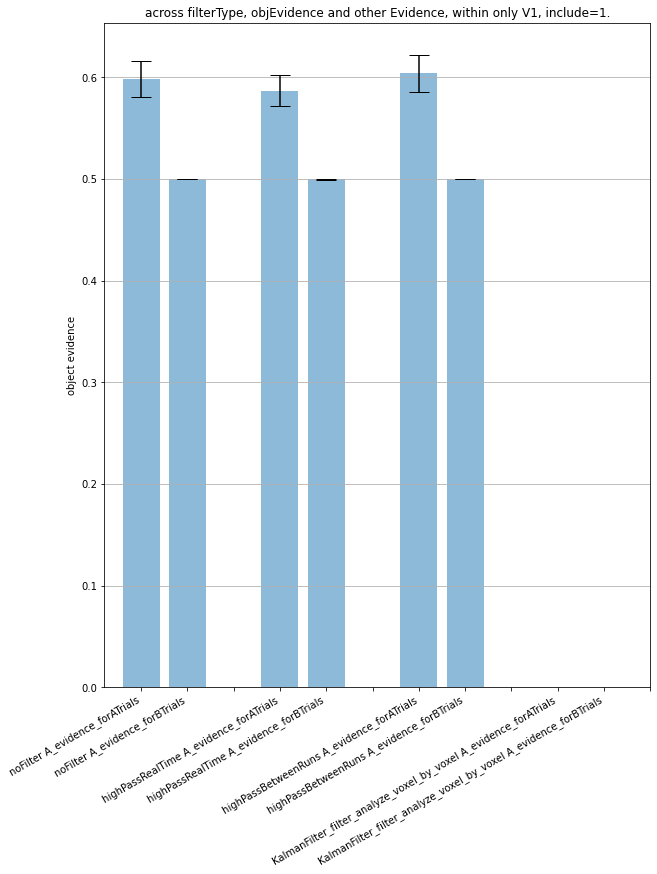

  9%|▉         | 931/10000 [00:00<00:00, 9208.03it/s]

L.shape= (32,)


  9%|▉         | 913/10000 [00:00<00:00, 9128.31it/s]

L.shape= (32,)


  9%|▉         | 917/10000 [00:00<00:00, 9165.25it/s]

L.shape= (32,)


  7%|▋         | 725/10000 [00:00<00:01, 7239.06it/s]

L.shape= (32,)


100%|██████████| 10000/10000 [00:01<00:00, 6883.28it/s]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


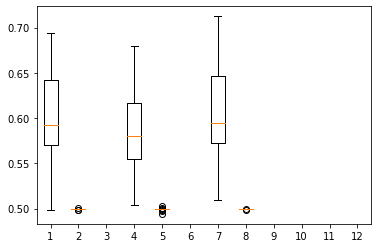

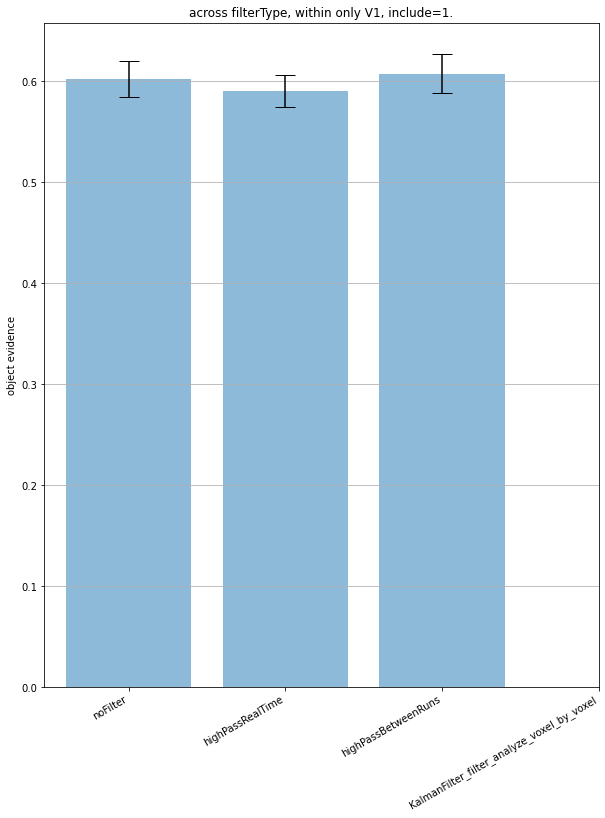

  9%|▉         | 946/10000 [00:00<00:00, 9456.15it/s]

L.shape= (32,)


 10%|▉         | 960/10000 [00:00<00:00, 9594.56it/s]

L.shape= (32,)


  9%|▉         | 921/10000 [00:00<00:00, 9183.58it/s]

L.shape= (32,)


  9%|▉         | 879/10000 [00:00<00:01, 8788.02it/s]

L.shape= (32,)


 10%|▉         | 954/10000 [00:00<00:00, 9539.60it/s]

L.shape= (32,)


100%|██████████| 10000/10000 [00:01<00:00, 9259.52it/s]


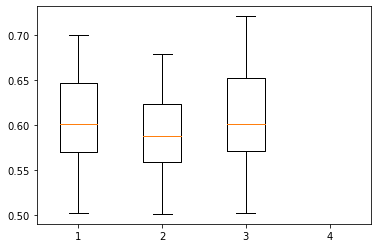

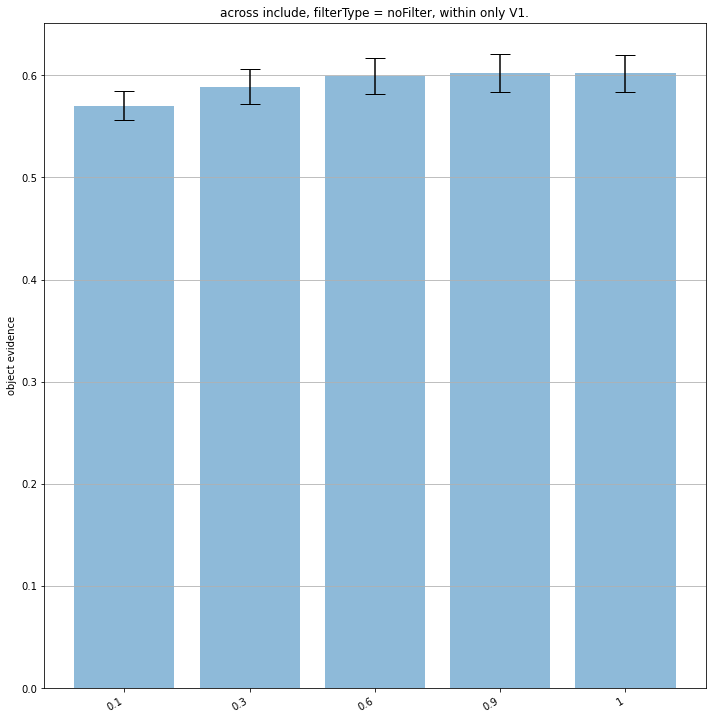

  0%|          | 0/32 [00:00<?, ?it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  3%|▎         | 1/32 [00:00<00:18,  1.64it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy o

 34%|███▍      | 11/32 [00:07<00:14,  1.50it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 38%|███▊      | 12/32 [00:07<00:12,  1.58it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

 69%|██████▉   | 22/32 [00:14<00:06,  1.62it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 72%|███████▏  | 23/32 [00:14<00:05,  1.63it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

  3%|▎         | 1/32 [00:00<00:20,  1.49it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  6%|▋         | 2/32 [00:01<00:19,  1.55it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on 

 38%|███▊      | 12/32 [00:07<00:11,  1.68it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 41%|████      | 13/32 [00:07<00:11,  1.64it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

 72%|███████▏  | 23/32 [00:13<00:05,  1.80it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 75%|███████▌  | 24/32 [00:14<00:04,  1.68it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

  6%|▋         | 2/32 [00:01<00:22,  1.34it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  9%|▉         | 3/32 [00:01<00:19,  1.46it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on 

 41%|████      | 13/32 [00:07<00:11,  1.68it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 44%|████▍     | 14/32 [00:08<00:10,  1.71it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

 75%|███████▌  | 24/32 [00:14<00:04,  1.64it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 78%|███████▊  | 25/32 [00:15<00:04,  1.60it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

  9%|▉         | 3/32 [00:01<00:17,  1.67it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 12%|█▎        | 4/32 [00:02<00:16,  1.70it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on 

 44%|████▍     | 14/32 [00:08<00:10,  1.67it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 47%|████▋     | 15/32 [00:09<00:09,  1.70it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

 78%|███████▊  | 25/32 [00:15<00:04,  1.63it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 81%|████████▏ | 26/32 [00:15<00:03,  1.65it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

 12%|█▎        | 4/32 [00:02<00:16,  1.74it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 16%|█▌        | 5/32 [00:02<00:15,  1.72it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on 

 47%|████▋     | 15/32 [00:09<00:11,  1.53it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 50%|█████     | 16/32 [00:09<00:09,  1.60it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

 81%|████████▏ | 26/32 [00:16<00:03,  1.61it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 84%|████████▍ | 27/32 [00:16<00:03,  1.61it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set o

L.shape= (32,)


  9%|▉         | 897/10000 [00:00<00:01, 8967.70it/s]

L.shape= (32,)


  9%|▉         | 895/10000 [00:00<00:01, 8948.81it/s]

L.shape= (32,)


  9%|▉         | 939/10000 [00:00<00:00, 9386.58it/s]

L.shape= (32,)


 10%|▉         | 953/10000 [00:00<00:00, 9526.40it/s]

L.shape= (32,)


100%|██████████| 10000/10000 [00:01<00:00, 8143.61it/s]


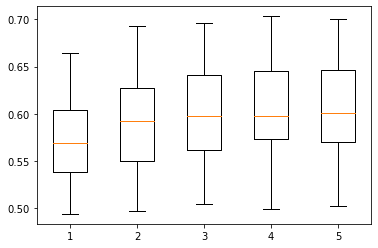

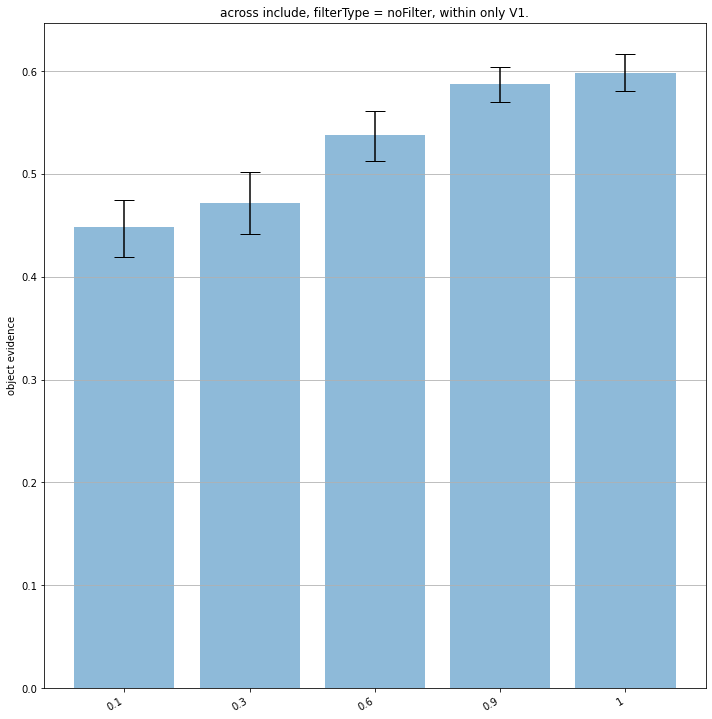

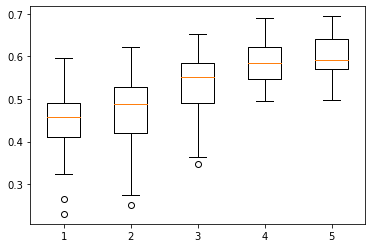

In [3]:
tag='condition2'

# modules and functions
import pandas as pd
import numpy as np
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt

def loadNpInDf(fileName):
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/FilterTesting/testMiniclass/'
    return np.load(main_dir+fileName+'.npy')

def preloadDfnumpy(testEvidence,List=['AC_A_evidence','AD_A_evidence','AC_B_evidence','AD_B_evidence','A_evidence_forATrials','A_evidence_forBTrials']):
    # this function convert the dataframe cell numpy array into real numpy array, was a string pointing to a file
    for i in range(len(testEvidence)):
        for L in List:
            testEvidence[L].iloc[i]=loadNpInDf(testEvidence[L].iloc[i])
    return testEvidence

def _and_(L):
    if len(L)==2:
        return np.logical_and(L[0],L[1])
    else:
        return np.logical_and(L[0],_and_(L[1:]))

def resample(L):
    L=np.asarray(L).reshape(-1)
    print('L.shape=',L.shape)
    sample_mean=[]
    for iter in tqdm(range(10000)):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m

def bar(LL,labels=None,title=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    plt.show()
    return m,lower,upper



# load saved results
accuracyContainer=[]
testEvidence=[]
for include in tqdm([0.1,0.3,0.6,0.9,1]):
    for roi in ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']:
        for filterType in ['noFilter','highPassRealTime','highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']:
            for testRun in [1,2,3,4,5,6]:
                if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
                    model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/{tag}/'
                else:
                    model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/'
#                 try:
                accuracyContainer.append(pd.read_csv(f"{model_folder}accuracy.csv"))
                testEvidence.append(pd.read_csv(f'{model_folder}testEvidence.csv'))
#                 except:
#                     pass
accuracyContainer=pd.concat(accuracyContainer, ignore_index=True)
testEvidence=pd.concat(testEvidence, ignore_index=True)


# across filterType, take the difference between objEvidence and other Evidence, within only V1, include=1.
subjects=np.unique(accuracyContainer['sub'])
filterType=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']

# I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
# for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
a=[]
labels=[]
for i in range(len(filterType)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
    c=[]
    d=[]

    # to get one single number for A_evidence_forATrials for each subject. 
    # you will need to extract the corresponding conditions and conbine the data together. 
    for sub in subjects:
        t=testEvidence[_and_([ #extract
            testEvidence['roi']=='V1',
            testEvidence['filterType']==filterType[i],
            testEvidence['include']==1.,
            testEvidence['sub']==sub
        ])]
        t=preloadDfnumpy(t)

        c.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials'])))) #conbine the data together
        d.append(np.nanmean(np.asarray(list(t['A_evidence_forBTrials']))))

    a.append(c)
    a.append(d)
    a.append([])
    labels.append(filterType[i] + ' A_evidence_forATrials')
    labels.append(filterType[i] + ' A_evidence_forBTrials')
    labels.append('')
bar(a,labels=labels,title='across filterType, objEvidence and other Evidence, within only V1, include=1.')

e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
_=plt.boxplot(e)




# accuracy: across filterType, take subject mean, within only V1, include=1.
subjects=np.unique(accuracyContainer['sub'])
filterType=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']
# I want to construction a list whose 1st element is the accuracy for noFilter, 2nd for highpass and so on.
# each element is 32 numbers for 32 subjects. each number is the mean accuracy for that subject.
a=[]
for i in range(len(filterType)):
    b=[]
    for sub in tqdm(subjects):
        try:
            b.append(np.mean(accuracyContainer[
                    _and_([
                        accuracyContainer['roi']=='V1', 
                        accuracyContainer['filterType']==filterType[i],
                        accuracyContainer['sub']==sub,
                        accuracyContainer['include']==1.
                    ])]['acc']))
        except:
            pass
    a.append(np.asarray(b))
bar(a,labels=list(filterType),title='across filterType, within only V1, include=1.')
e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
_=plt.boxplot(e)




# compare between includes using accuracy
# I want to construct a comparison between different includes by having includes
includes=[0.1,0.3,0.6,0.9,1]
filterType='noFilter'
a=[]
for include in includes:
    b=[]
    for sub in tqdm(subjects):
        try:
            b.append(np.mean(accuracyContainer[
                    _and_([
                        accuracyContainer['roi']=='V1', 
                        accuracyContainer['filterType']==filterType,
                        accuracyContainer['sub']==sub,
                        accuracyContainer['include']==np.float(include)
                    ])]['acc']))
        except:
            pass
    a.append(np.asarray(b))
bar(a,labels=list(includes),title=f'across include, filterType = {filterType}, within only V1.')
_=plt.figure()
e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
_=plt.boxplot(e)

# compare between includes using evidence
# I want to construct a comparison between different includes by having includes
includes=[0.1,0.3,0.6,0.9,1]
filterType='noFilter'
a=[]
for include in includes:
    b=[]
    for sub in tqdm(subjects):
        t=testEvidence[_and_([ #extract
            testEvidence['roi']=='V1',
            testEvidence['filterType']==filterType,
            testEvidence['include']==np.float(include),
            testEvidence['sub']==sub
        ])]
        t=preloadDfnumpy(t)
        b.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials']))))
    a.append(np.asarray(b))
bar(a,labels=list(includes),title=f'across include, filterType = {filterType}, within only V1.')
_=plt.figure()
e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
_=plt.boxplot(e)


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

L.shape= (7200,)


  3%|▎         | 303/10000 [00:00<00:03, 3027.96it/s]

L.shape= (7200,)


  6%|▌         | 601/10000 [00:00<00:01, 6007.63it/s]

L.shape= (0,)


100%|██████████| 10000/10000 [00:01<00:00, 6053.30it/s]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
  3%|▎         | 318/10000 [00:00<00:03, 3179.89it/s]

L.shape= (7200,)


  3%|▎         | 312/10000 [00:00<00:03, 3115.03it/s]

L.shape= (7200,)


  6%|▋         | 632/10000 [00:00<00:01, 6312.54it/s]

L.shape= (0,)


  3%|▎         | 319/10000 [00:00<00:03, 3187.34it/s]

L.shape= (7200,)


  3%|▎         | 315/10000 [00:00<00:03, 3147.17it/s]

L.shape= (7200,)


  6%|▋         | 631/10000 [00:00<00:01, 6305.12it/s]

L.shape= (0,)


  3%|▎         | 330/10000 [00:00<00:02, 3295.56it/s]

L.shape= (7200,)


  3%|▎         | 258/10000 [00:00<00:03, 2561.43it/s]

L.shape= (7200,)


  3%|▎         | 255/10000 [00:00<00:03, 2531.97it/s]

L.shape= (0,)


100%|██████████| 10000/10000 [00:01<00:00, 5437.03it/s]


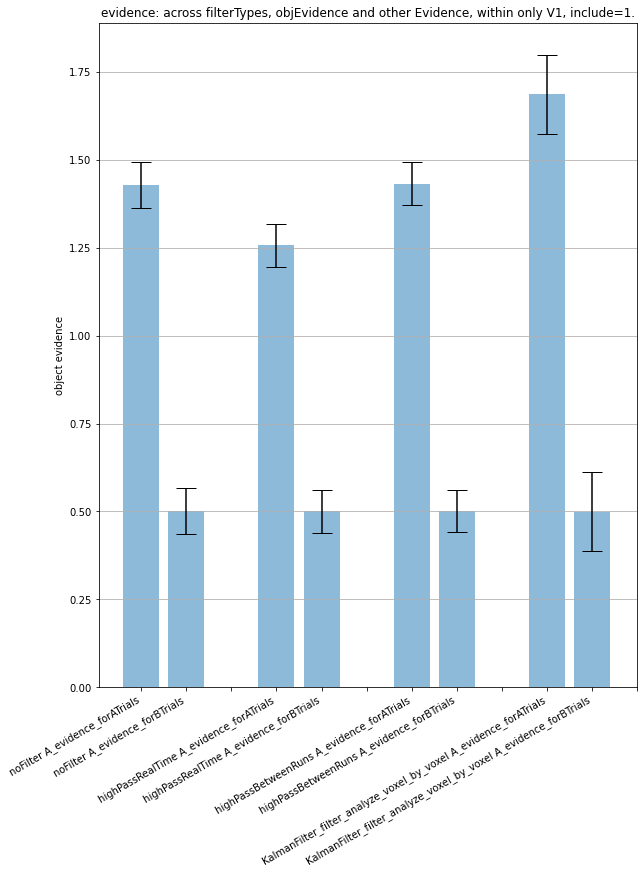

NameError: name 'itertools' is not defined

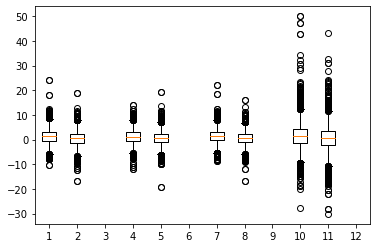

In [42]:
tag='condition4'

# modules and functions
import pandas as pd
import numpy as np
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt

def loadNpInDf(fileName):
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/FilterTesting/testMiniclass/'
    return np.load(main_dir+fileName+'.npy')

def preloadDfnumpy(testEvidence,List=['AC_A_evidence','AD_A_evidence','AC_B_evidence','AD_B_evidence','A_evidence_forATrials','A_evidence_forBTrials']):
    # this function convert the dataframe cell numpy array into real numpy array, was a string pointing to a file
    for i in range(len(testEvidence)):
        for L in List:
            testEvidence[L].iloc[i]=loadNpInDf(testEvidence[L].iloc[i])
    return testEvidence

def _and_(L):
    if len(L)==2:
        return np.logical_and(L[0],L[1])
    else:
        return np.logical_and(L[0],_and_(L[1:]))

def resample(L):
    L=np.asarray(L).reshape(-1)
    print('L.shape=',L.shape)
    sample_mean=[]
    for iter in tqdm(range(10000)):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m

def bar(LL,labels=None,title=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    plt.show()
    return m,lower,upper

def assertKeys(t0,t1,keys=['testRun','targetAxis','obj','otherObj']):
    # this function compare the given keys of the given two df and return true if they are exactly the same
    for key in keys:
        if not np.all(np.asarray(t1[key])==np.asarray(t0[key])):
            return False
    return True

# load saved results
accuracyContainer=[]
testEvidence=[]
for include in tqdm([0.1,0.3,0.6,0.9,1]):
    for roi in ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']:
        for filterType in ['noFilter','highPassRealTime','highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']:
            for testRun in [1,2,3,4,5,6]:
                # if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
                model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/{tag}/'
                # else:
                #     model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/'
                try:
                    accuracyContainer.append(pd.read_csv(f"{model_folder}accuracy.csv"))
                    testEvidence.append(pd.read_csv(f'{model_folder}testEvidence.csv'))
                except:
                    pass
accuracyContainer=pd.concat(accuracyContainer, ignore_index=True)
testEvidence=pd.concat(testEvidence, ignore_index=True)

ROI="V1"
global filterTypes,subjects,ROIs
filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']
subjects=np.unique(accuracyContainer['sub'])
ROIs=['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']


def concatArrayArray(c): #[array[],array[]]
    ct=[]
    for i in range(len(c)):
        ct=ct+[list(i) for i in c][i]
    return ct


# I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
# for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
a=[]
labels=[]
for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
    c=[]
    d=[]

    # to get one single number for A_evidence_forATrials for each subject. 
    # you will need to extract the corresponding conditions and conbine the data together. 
    for sub in subjects:
        t=testEvidence[_and_([ #extract
            testEvidence['roi']==ROI,
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==sub
        ])]
        t=preloadDfnumpy(t)

        c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
        d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

#     a.append(np.asarray(c).reshape(-1))
#     a.append(np.asarray(d).reshape(-1))
    a.append(concatArrayArray(c))
    a.append(concatArrayArray(d))
    a.append([])
    labels.append(filterTypes[i] + ' A_evidence_forATrials')
    labels.append(filterTypes[i] + ' A_evidence_forBTrials')
    labels.append('')
bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.')

e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
_=plt.boxplot(e)

import itertools
# paired t-test
objects=np.arange(4)
allpairs = itertools.combinations(objects,2)
for pair in allpairs:
    i=pair[0]
    j=pair[1]
    print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")


In [2]:
ROI="V1"
# I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
# for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
a=[]
labels=[]
for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
    c=[]
    d=[]

    # to get one single number for A_evidence_forATrials for each subject. 
    # you will need to extract the corresponding conditions and conbine the data together. 
    for sub in subjects:
        t=testEvidence[_and_([ #extract
            testEvidence['roi']==ROI,
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==sub
        ])]
        t=preloadDfnumpy(t)

        c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
        d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

    a.append(np.asarray(c).reshape(-1))
    a.append(np.asarray(d).reshape(-1))
    a.append([])
    labels.append(filterTypes[i] + ' A_evidence_forATrials')
    labels.append(filterTypes[i] + ' A_evidence_forBTrials')
    labels.append('')
bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.')

e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
_=plt.boxplot(e)

# paired t-test
objects=np.arange(4)
allpairs = itertools.combinations(objects,2)
for pair in allpairs:
    i=pair[0]
    j=pair[1]
    print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

L.shape= (5760,)


  5%|▍         | 498/10000 [00:00<00:01, 4976.34it/s]

L.shape= (5760,)


 10%|█         | 1025/10000 [00:00<00:00, 10244.25it/s]

L.shape= (0,)


100%|██████████| 10000/10000 [00:00<00:00, 10290.88it/s]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
  5%|▍         | 498/10000 [00:00<00:01, 4976.62it/s]

L.shape= (5760,)


  5%|▌         | 500/10000 [00:00<00:01, 4996.85it/s]

L.shape= (5760,)


 11%|█         | 1067/10000 [00:00<00:00, 10661.22it/s]

L.shape= (0,)


  5%|▍         | 498/10000 [00:00<00:01, 4977.81it/s]

L.shape= (5760,)


  5%|▍         | 498/10000 [00:00<00:01, 4978.26it/s]

L.shape= (5760,)


 11%|█         | 1063/10000 [00:00<00:00, 10627.53it/s]

L.shape= (0,)


  0%|          | 0/10000 [00:00<?, ?it/s]


L.shape= (4,)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [9]:
# This code is a copy from the recog_features.py but to deal with the output filtered
# brain data using Kalman filtering generated by Alex.

'''
The "input" of this code is 
    regressor file: recog_reg 
        which looks like three colum regressors that are used in FEAT, each object (ABCD) has a seperate regressor file?
    raw brain data: 

    where is the behavior data? at what time is each image presented? That would be the regressor file
'''

import pandas as pd
import nibabel as nib
from glob import glob
import os
from subprocess import call
import sys
import numpy as np    
import time
# sys.path.append('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten')
import ray
from pykalman import KalmanFilter
from tqdm import tqdm

ray.init(ignore_reinit_error=True)
@ray.remote(num_cpus = 0.5)
def kalman_filter_voxel(measurement):
    kf = KalmanFilter(n_dim_state = measurement.shape[1], n_dim_obs = measurement.shape[1], 
                          observation_matrices = np.eye(measurement.shape[1]),
                          observation_covariance = np.eye(measurement.shape[1]),
                          observation_offsets = np.zeros(measurement.shape[1]))
    kf = kf.em(measurement, n_iter=5,
                  em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
                  )
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurement)
    return filtered_state_means.reshape(-1)
    
def filtering(timeseries=None, filterType='highPassRealTime'): 
    '''
    filterType can be 
        highPassRealTime 
        highPassBetweenRuns 
        UnscentedKalmanFilter_filter # documentation: https://pykalman.github.io/
        UnscentedKalmanFilter_smooth
        KalmanFilter_filter
        KalmanFilter_smooth
        noFilter
    '''
    timeseries=timeseries.astype(np.float)
    oldShape=timeseries.shape
    timeseries=timeseries.reshape(timeseries.shape[0],-1)
    if filterType == 'highPassRealTime':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassRealTime(A_matrix, TR, cutoff):
            full_matrix = np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), True))
            return full_matrix[-1, :]

        filtered_timeseries=[]
        for currTR in range(timeseries.shape[0]):
            filtered_timeseries.append(highPassRealTime(timeseries[:(currTR+1)],1.5,56))
        filtered_timeseries = np.asarray(filtered_timeseries)
    elif filterType == 'highPassBetweenRuns':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassBetweenRuns(A_matrix, TR, cutoff):
            return np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), False))

        filtered_timeseries = highPassBetweenRuns(timeseries,1.5,56)
    elif filterType == 'KalmanFilter_filter_analyze_voxel_by_voxel':
        filtered_timeseries=np.zeros(timeseries.shape)
        print("time series shape", timeseries.shape)
        futures = []
        for curr_voxel in range(timeseries.shape[1]):
            measurements = np.asarray(timeseries[:,curr_voxel].reshape(-1, 1)) 
            futures.append(kalman_filter_voxel.remote(measurements))
        results = ray.get(futures)
        filtered_timeseries = np.array(results).T # transpose because results are organized by [voxel, time] 
        print("filtered_timeseries=", filtered_timeseries)
    # elif filterType == 'UnscentedKalmanFilter_filter' :
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (filtered_timeseries_state_means, filtered_timeseries_state_covariances) = ukf.filter(timeseries[:,curr_voxel])
    #         filtered_timeseries[:,curr_voxel] = filtered_timeseries_state_means.reshape(-1)
    # elif filterType == 'UnscentedKalmanFilter_smooth':
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (smoothed_state_means, smoothed_state_covariances) = ukf.smooth(data)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter_analyze_all_voxels': # KALMAN FILTER ALL VOXELS NOT WORKING
    #     print('oldShape=',oldShape)
    #     kf = KalmanFilter(n_dim_state = oldShape[1], n_dim_obs = oldShape[1], 
    #                       observation_matrices = np.eye(oldShape[1]),
    #                       observation_covariance = np.eye(oldShape[1]),
    #                       observation_offsets = np.zeros(oldShape[1]))
    #     print("time series shape", timeseries.shape)
    #     kf = kf.em(timeseries, run, n_iter=5,
    #               em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
    #                         'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    #               )
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #     filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #         filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(n_dim_obs = timeseries.shape[1], n_dim_state = timeseries.shape[1], 
    #                           observation_matrices = sparse.eye(timeseries.shape[1]), 
    #                           observation_offsets = np.zeros(timeseries.shape[1]),
    #                           observation_covariance = sparse.eye(timeseries.shape[1]))
    #     kf = kf.em(timeseries, run, n_iter=10)
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(timeseries)
    #     filtered_timeseries = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_smooth':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    elif filterType == 'noFilter':
        filtered_timeseries = timeseries
    else:
        raise Exception('filterType wrong')

    filtered_timeseries=filtered_timeseries.reshape(oldShape)
    return filtered_timeseries


def recog_features(subject='0110171',filterType = 'highPassBetweenRuns',tag=''):

    os.chdir('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/')
    subject = subject.split('_')[0]
    proj_dir = '/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/'
    dat_type = 'recog'
    data_dir = os.path.abspath(os.path.join(proj_dir,'features')) # this is the output folder where output features are saved

    # INPUT: brain data
    feature_dir = os.path.abspath(os.path.join(data_dir, filterType)) #This is the output folder, where the output features are saved
    if not os.path.isdir(feature_dir):
        os.mkdir(feature_dir)
    filt_func = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/data/nifti/realtime_preprocessed',
        '{}_neurosketch_recognition_run_{}.nii.gz')) # input, the continuous time series, brain data.
    recog_reg = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/regressor/run_{}/{}.txt')) # this is regressor file

    roi_dir = os.path.abspath(os.path.join(proj_dir,'subjects/{}_neurosketch/analysis/firstlevel/rois'))

    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/surfroi/0110171_neurosketch_V1.nii.gz    88*128*128
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_anat_mprage_brain.nii.gz.   256*256*176
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_run_1.nii.gz 94*94*72 #note V1_func_run_{1~6}.nii.gz are the same
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_recognition_run_1.nii.gz 94*94*72

    out_dir = os.path.abspath(os.path.join(feature_dir, 'recognition',tag)) 
    call(f"mkdir -p {out_dir}",shell=True)
    # if not os.path.isdir(out_dir):
        # os.mkdir(out_dir)

    objects = ['bed', 'bench', 'chair', 'table']
    roi_list_masks = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1', 'V2','LOC_FS','IT_FS','fusiform_FS','parahippo_FS','PRC_FS','ento_FS','hipp_FS','V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']
    roi_list_names = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp', 'V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']

    for curr_phase,phase in enumerate(['12', '34', '56']):
        # initialize data columns
        subj = [subject] * 160
        label = []
        run_num = [phase[0]]*80 + [phase[1]]*80
        TR_num = []
        for roi, roiname in zip(roi_list_masks, roi_list_names):
            for rn, run in enumerate(phase): # phase is '12' or '34' or '56'
                print('creating features for run {}'.format(run))

                # load subject's time series for this run
                # timeseries = nib.load(filt_func.format(subject, subject, run))
                # timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
                
                # A=time.time()
                # timeseries = filtering(timeseries=timeseries, filterType=filterType)
                # B=time.time()
                # print('timeseries.shape=',timeseries.shape)
                # print(f'filtering time passed={B-A} s for run {run} ')

                
                if tag=='':
                    timeseries = np.load(f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/filtered_timeSeries/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition1':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy") #condition1
                elif tag=='condition2':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition3':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs_refit_filter/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition4':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                                           
                # use information in regressor/run_x folder to make hasImage vector
                # associated TR is just the hasImage index, converted to a float
                Onsets = [0]*240
                for obj in objects:
                    with open(recog_reg.format(subject, run, obj)) as f:
                        times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                        for t in times:
                            TR = int(float(t)/1.5)
                            Onsets[TR] = obj

                # wherever hasImage, we want the features, aka only keep the features when there 
                # is an image shown
                features = [timeseries[n+3] for n, onset in enumerate(Onsets) if onset != 0] # move the timeseries by 3TRs, only keep the features when an image is shown
                labels = [label for label in Onsets if label != 0]
                FEATURES = np.array(features) if rn == 0 else np.vstack((FEATURES, np.array(features)))
                LABELS = labels if rn == 0 else LABELS + labels
            np.save('{}/{}_{}_{}_featurematrix.npy'.format(out_dir, subject, roiname, phase), FEATURES)
        
            ## metadata
            x = pd.DataFrame([subj, LABELS, run_num, TR_num]) # lists of the same length
            x = x.transpose()
            x.columns = ['subj','label','run_num', 'TR_num']
            x.to_csv('{}/metadata_{}_{}_{}.csv'.format(out_dir, subject, roiname, phase))

            # if curr_phase==0:
            #     FEATURES_oldShape=FEATURES.shape
            # else:
            #     assert np.allclose(FEATURES.shape,FEATURES_oldShape),"FEATURES shape not match"

        np.save('{}/{}_{}_featurematrix.npy'.format(out_dir, subject, phase), FEATURES)
        
#         for roi, roiname in zip(roi_list_masks, roi_list_names):
#             # mask = nib.load('{}/{}.nii.gz'.format(roi_dir.format(subject), roi))
#             # mask = nib.load('{}/{}_func_combined_{}_binarized.nii.gz'.format(roi_dir.format(subject), roi,'12')) #here the phase is fixed to '12' because I found that different phases mask are different, e.g. fslview_deprecated /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_12_binarized.nii.gz /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_34_binarized.nii.gz are not the same!
#             # maskDat = mask.get_data()
#             masked = FEATURES[:, maskDat == 1]
            

#installing rtAtten is very simple, just `conda env create -f environment.yml ; source activate rtAtten ; python setup.py install`
working_dir='/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/' 
os.chdir(working_dir)
print('pwd=',os.getcwd())
print('CONDA_DEFAULT_ENV=',os.environ['CONDA_DEFAULT_ENV'])
subject_dir='/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/'
subjects=glob(subject_dir+'*_neurosketch')
subjects=[sub.split('/')[-1].split('_')[0] for sub in subjects if sub.split('/')[-1][0]!='_']
subjects=['1206161', '1201161', '1206163', '0110171'] #['0110171','1206161']

tag='condition4'

for sub in tqdm(subjects):
    filterType='KalmanFilter_filter_analyze_voxel_by_voxel'
    print('sub=',sub)
    print('filterType=',filterType)

#     try:
    recog_features(subject=sub, filterType = filterType,tag=tag)
#     except:
#         pass


2020-11-11 09:52:36,002	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.
  0%|          | 0/4 [00:00<?, ?it/s]

pwd= /gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten
CONDA_DEFAULT_ENV= /gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten
sub= 1206161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run

 25%|██▌       | 1/4 [00:03<00:09,  3.25s/it]

creating features for run 5
creating features for run 6
sub= 1201161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/V1/V1_Kalman_filter_1201161_1_featurematrix.npy'

In [22]:
# This code is a copy from the recog_features.py but to deal with the output filtered
# brain data using Kalman filtering generated by Alex.

'''
The "input" of this code is 
    regressor file: recog_reg 
        which looks like three colum regressors that are used in FEAT, each object (ABCD) has a seperate regressor file?
    raw brain data: 

    where is the behavior data? at what time is each image presented? That would be the regressor file
'''

import pandas as pd
import nibabel as nib
from glob import glob
import os
from subprocess import call
import sys
import numpy as np    
import time
# sys.path.append('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten')
import ray
from pykalman import KalmanFilter
from tqdm import tqdm

ray.init(ignore_reinit_error=True)
@ray.remote(num_cpus = 0.5)
def kalman_filter_voxel(measurement):
    kf = KalmanFilter(n_dim_state = measurement.shape[1], n_dim_obs = measurement.shape[1], 
                          observation_matrices = np.eye(measurement.shape[1]),
                          observation_covariance = np.eye(measurement.shape[1]),
                          observation_offsets = np.zeros(measurement.shape[1]))
    kf = kf.em(measurement, n_iter=5,
                  em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
                  )
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurement)
    return filtered_state_means.reshape(-1)
    
def filtering(timeseries=None, filterType='highPassRealTime'): 
    '''
    filterType can be 
        highPassRealTime 
        highPassBetweenRuns 
        UnscentedKalmanFilter_filter # documentation: https://pykalman.github.io/
        UnscentedKalmanFilter_smooth
        KalmanFilter_filter
        KalmanFilter_smooth
        noFilter
    '''
    timeseries=timeseries.astype(np.float)
    oldShape=timeseries.shape
    timeseries=timeseries.reshape(timeseries.shape[0],-1)
    if filterType == 'highPassRealTime':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassRealTime(A_matrix, TR, cutoff):
            full_matrix = np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), True))
            return full_matrix[-1, :]

        filtered_timeseries=[]
        for currTR in range(timeseries.shape[0]):
            filtered_timeseries.append(highPassRealTime(timeseries[:(currTR+1)],1.5,56))
        filtered_timeseries = np.asarray(filtered_timeseries)
    elif filterType == 'highPassBetweenRuns':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassBetweenRuns(A_matrix, TR, cutoff):
            return np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), False))

        filtered_timeseries = highPassBetweenRuns(timeseries,1.5,56)
    elif filterType == 'KalmanFilter_filter_analyze_voxel_by_voxel':
        filtered_timeseries=np.zeros(timeseries.shape)
        print("time series shape", timeseries.shape)
        futures = []
        for curr_voxel in range(timeseries.shape[1]):
            measurements = np.asarray(timeseries[:,curr_voxel].reshape(-1, 1)) 
            futures.append(kalman_filter_voxel.remote(measurements))
        results = ray.get(futures)
        filtered_timeseries = np.array(results).T # transpose because results are organized by [voxel, time] 
        print("filtered_timeseries=", filtered_timeseries)
    # elif filterType == 'UnscentedKalmanFilter_filter' :
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (filtered_timeseries_state_means, filtered_timeseries_state_covariances) = ukf.filter(timeseries[:,curr_voxel])
    #         filtered_timeseries[:,curr_voxel] = filtered_timeseries_state_means.reshape(-1)
    # elif filterType == 'UnscentedKalmanFilter_smooth':
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (smoothed_state_means, smoothed_state_covariances) = ukf.smooth(data)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter_analyze_all_voxels': # KALMAN FILTER ALL VOXELS NOT WORKING
    #     print('oldShape=',oldShape)
    #     kf = KalmanFilter(n_dim_state = oldShape[1], n_dim_obs = oldShape[1], 
    #                       observation_matrices = np.eye(oldShape[1]),
    #                       observation_covariance = np.eye(oldShape[1]),
    #                       observation_offsets = np.zeros(oldShape[1]))
    #     print("time series shape", timeseries.shape)
    #     kf = kf.em(timeseries, run, n_iter=5,
    #               em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
    #                         'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    #               )
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #     filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #         filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(n_dim_obs = timeseries.shape[1], n_dim_state = timeseries.shape[1], 
    #                           observation_matrices = sparse.eye(timeseries.shape[1]), 
    #                           observation_offsets = np.zeros(timeseries.shape[1]),
    #                           observation_covariance = sparse.eye(timeseries.shape[1]))
    #     kf = kf.em(timeseries, run, n_iter=10)
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(timeseries)
    #     filtered_timeseries = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_smooth':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    elif filterType == 'noFilter':
        filtered_timeseries = timeseries
    else:
        raise Exception('filterType wrong')

    filtered_timeseries=filtered_timeseries.reshape(oldShape)
    return filtered_timeseries


def recog_features(subject='0110171',filterType = 'highPassBetweenRuns',tag=''):

    os.chdir('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/')
    subject = subject.split('_')[0]
    proj_dir = '/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/'
    dat_type = 'recog'
    data_dir = os.path.abspath(os.path.join(proj_dir,'features')) # this is the output folder where output features are saved

    # INPUT: brain data
    feature_dir = os.path.abspath(os.path.join(data_dir, filterType)) #This is the output folder, where the output features are saved
    if not os.path.isdir(feature_dir):
        os.mkdir(feature_dir)
    filt_func = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/data/nifti/realtime_preprocessed',
        '{}_neurosketch_recognition_run_{}.nii.gz')) # input, the continuous time series, brain data.
    recog_reg = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/regressor/run_{}/{}.txt')) # this is regressor file

    roi_dir = os.path.abspath(os.path.join(proj_dir,'subjects/{}_neurosketch/analysis/firstlevel/rois'))

    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/surfroi/0110171_neurosketch_V1.nii.gz    88*128*128
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_anat_mprage_brain.nii.gz.   256*256*176
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_run_1.nii.gz 94*94*72 #note V1_func_run_{1~6}.nii.gz are the same
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_recognition_run_1.nii.gz 94*94*72

    out_dir = os.path.abspath(os.path.join(feature_dir, 'recognition',tag)) 
    call(f"mkdir -p {out_dir}",shell=True)
    # if not os.path.isdir(out_dir):
        # os.mkdir(out_dir)

    objects = ['bed', 'bench', 'chair', 'table']
    roi_list_masks = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1', 'V2','LOC_FS','IT_FS','fusiform_FS','parahippo_FS','PRC_FS','ento_FS','hipp_FS','V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']
    roi_list_names = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp', 'V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']

    for curr_phase,phase in enumerate(['12', '34', '56']):
        # initialize data columns
        subj = [subject] * 160
        label = []
        run_num = [phase[0]]*80 + [phase[1]]*80
        TR_num = []
        for roi, roiname in zip(roi_list_masks, roi_list_names):
            for rn, run in enumerate(phase): # phase is '12' or '34' or '56'
                print('creating features for run {}'.format(run))

                # load subject's time series for this run
                # timeseries = nib.load(filt_func.format(subject, subject, run))
                # timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
                
                # A=time.time()
                # timeseries = filtering(timeseries=timeseries, filterType=filterType)
                # B=time.time()
                # print('timeseries.shape=',timeseries.shape)
                # print(f'filtering time passed={B-A} s for run {run} ')

                
                if tag=='':
                    timeseries = np.load(f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/filtered_timeSeries/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition1':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy") #condition1
                elif tag=='condition2':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition3':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs_refit_filter/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition4':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                                           
                # use information in regressor/run_x folder to make hasImage vector
                # associated TR is just the hasImage index, converted to a float
                Onsets = [0]*240
                for obj in objects:
                    with open(recog_reg.format(subject, run, obj)) as f:
                        times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                        for t in times:
                            TR = int(float(t)/1.5)
                            Onsets[TR] = obj

                # wherever hasImage, we want the features, aka only keep the features when there 
                # is an image shown
                features = [timeseries[n+3] for n, onset in enumerate(Onsets) if onset != 0] # move the timeseries by 3TRs, only keep the features when an image is shown
                labels = [label for label in Onsets if label != 0]
                FEATURES = np.array(features) if rn == 0 else np.vstack((FEATURES, np.array(features)))
                LABELS = labels if rn == 0 else LABELS + labels
            np.save('{}/{}_{}_{}_featurematrix.npy'.format(out_dir, subject, roiname, phase), FEATURES)
        
            ## metadata
            x = pd.DataFrame([subj, LABELS, run_num, TR_num]) # lists of the same length
            x = x.transpose()
            x.columns = ['subj','label','run_num', 'TR_num']
            x.to_csv('{}/metadata_{}_{}_{}.csv'.format(out_dir, subject, roiname, phase))

            # if curr_phase==0:
            #     FEATURES_oldShape=FEATURES.shape
            # else:
            #     assert np.allclose(FEATURES.shape,FEATURES_oldShape),"FEATURES shape not match"

        np.save('{}/{}_{}_featurematrix.npy'.format(out_dir, subject, phase), FEATURES)
        
#         for roi, roiname in zip(roi_list_masks, roi_list_names):
#             # mask = nib.load('{}/{}.nii.gz'.format(roi_dir.format(subject), roi))
#             # mask = nib.load('{}/{}_func_combined_{}_binarized.nii.gz'.format(roi_dir.format(subject), roi,'12')) #here the phase is fixed to '12' because I found that different phases mask are different, e.g. fslview_deprecated /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_12_binarized.nii.gz /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_34_binarized.nii.gz are not the same!
#             # maskDat = mask.get_data()
#             masked = FEATURES[:, maskDat == 1]
            

#installing rtAtten is very simple, just `conda env create -f environment.yml ; source activate rtAtten ; python setup.py install`
working_dir='/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/' 
os.chdir(working_dir)
print('pwd=',os.getcwd())
print('CONDA_DEFAULT_ENV=',os.environ['CONDA_DEFAULT_ENV'])
subject_dir='/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/'
subjects=glob(subject_dir+'*_neurosketch')
subjects=[sub.split('/')[-1].split('_')[0] for sub in subjects if sub.split('/')[-1][0]!='_']
subjects=['0110171', '1206161', '0120171', '1206161', '1206163'] #['1206161', '1201161', '1206163', '0110171'] #['0110171','1206161']

tag='condition4'

for sub in tqdm(subjects):
    filterType='KalmanFilter_filter_analyze_voxel_by_voxel'
    print('sub=',sub)
    print('filterType=',filterType)

#     try:
    recog_features(subject=sub, filterType = filterType,tag=tag)
#     except:
#         pass


# This script only need to be run sepearately, doesn't need any parent script to run. e.g. in the jupyter notebok in rtAtten environment

2020-11-11 10:04:10,519	ERROR worker.py:643 -- Calling ray.init() again after it has already been called.
  0%|          | 0/5 [00:00<?, ?it/s]

pwd= /gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten
CONDA_DEFAULT_ENV= /gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten
sub= 0110171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run

 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

creating features for run 5
creating features for run 6
sub= 1206161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 40%|████      | 2/5 [00:06<00:09,  3.02s/it]

creating features for run 5
creating features for run 6
sub= 0120171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

creating features for run 5
creating features for run 6
sub= 1206161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 80%|████████  | 4/5 [00:11<00:02,  2.94s/it]

sub= 1206163
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

creating features for run 5
creating features for run 6


In [2]:
tag='condition4'

# modules and functions
import pandas as pd
import numpy as np
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import itertools
from scipy import stats

def loadNpInDf(fileName):
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/FilterTesting/testMiniclass/'
    return np.load(main_dir+fileName+'.npy')

def preloadDfnumpy(testEvidence,List=['AC_A_evidence','AD_A_evidence','AC_B_evidence','AD_B_evidence','A_evidence_forATrials','A_evidence_forBTrials']):
    # this function convert the dataframe cell numpy array into real numpy array, was a string pointing to a file
    for i in range(len(testEvidence)):
        for L in List:
            testEvidence[L].iloc[i]=loadNpInDf(testEvidence[L].iloc[i])
    return testEvidence

def _and_(L):
    if len(L)==2:
        return np.logical_and(L[0],L[1])
    else:
        return np.logical_and(L[0],_and_(L[1:]))

def resample(L):
    L=np.asarray(L).reshape(-1)
    print('L.shape=',L.shape)
    sample_mean=[]
    for iter in range(10000):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m

def bar(LL,labels=None,title=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    plt.show()
    return m,lower,upper

def assertKeys(t0,t1,keys=['testRun','targetAxis','obj','otherObj']):
    # this function compare the given keys of the given two df and return true if they are exactly the same
    for key in keys:
        if not np.all(np.asarray(t1[key])==np.asarray(t0[key])):
            return False
    return True

def concatArrayArray(c): #[array[],array[]]
    ct=[]
    for i in range(len(c)):
        ct=ct+[list(i) for i in c][i]
    return ct

# load saved results
accuracyContainer=[]
testEvidence=[]
for include in tqdm([0.1,0.3,0.6,0.9,1]):
    for roi in ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']:
        for filterType in ['noFilter','highPassRealTime','highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']:
            for testRun in [1,2,3,4,5,6]:
                # if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
                model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/{tag}/'
                # else:
                #     model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/'
                try:
                    accuracyContainer.append(pd.read_csv(f"{model_folder}accuracy.csv"))
                    testEvidence.append(pd.read_csv(f'{model_folder}testEvidence.csv'))
                except:
                    pass
accuracyContainer=pd.concat(accuracyContainer, ignore_index=True)
testEvidence=pd.concat(testEvidence, ignore_index=True)


global filterTypes,subjects,ROIs
filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']
subjects=np.unique(accuracyContainer['sub'])
ROIs=['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']


# def evidenceAcrossFiltertypes(ROI="V1"):
#     # I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
#     # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
#     a=[]
#     labels=[]
#     for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
#         c=[]
#         d=[]

#         # to get one single number for A_evidence_forATrials for each subject. 
#         # you will need to extract the corresponding conditions and conbine the data together. 
#         for sub in subjects:
#             t=testEvidence[_and_([ #extract
#                 testEvidence['roi']==ROI,
#                 testEvidence['filterType']==filterTypes[i],
#                 testEvidence['include']==1.,
#                 testEvidence['sub']==sub
#             ])]
#             t=preloadDfnumpy(t)

#             c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
#             d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

#         a.append(concatArrayArray(c))
#         a.append(concatArrayArray(d))
#         a.append([])
#         labels.append(filterTypes[i] + ' A_evidence_forATrials')
#         labels.append(filterTypes[i] + ' A_evidence_forBTrials')
#         labels.append('')
#     bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.')

#     e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
#     _=plt.boxplot(e)

#     # paired t-test
#     objects=np.arange(4)
#     allpairs = itertools.combinations(objects,2)
#     for pair in allpairs:
#         i=pair[0]
#         j=pair[1]
#         print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")

# for i in range(len(ROIs)):
#     evidenceAcrossFiltertypes(ROI=ROIs[i])


100%|██████████| 5/5 [01:09<00:00, 13.88s/it]


In [11]:
a=np.array([0.44, 0.42, 0.38, 0.3, 0.6, 0.51, 0.54, 0.52, 0.71, 0.65])
a[a>0.5]=1
a[a<=0.5]=0
print(np.mean(a))

b=np.array([0.44, 0.42, 0.38, 0.3, 0.6, 0.51, 0.54, 0.52, 0.71, 0.65])
b=b+0.04
b[b>0.5]=1
b[b<=0.5]=0
print(np.mean(b))


0.6
0.6


In [17]:
tag='condition4'

# modules and functions
import pandas as pd
import numpy as np
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import itertools
from scipy import stats

def loadNpInDf(fileName):
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/FilterTesting/testMiniclass/'
    return np.load(main_dir+fileName+'.npy')

def preloadDfnumpy(testEvidence,List=['AC_A_evidence','AD_A_evidence','AC_B_evidence','AD_B_evidence','A_evidence_forATrials','A_evidence_forBTrials']):
    # this function convert the dataframe cell numpy array into real numpy array, was a string pointing to a file
    import warnings
    warnings.filterwarnings("ignore")
    for i in range(len(testEvidence)):
        for L in List:
            testEvidence[L].iloc[i]=loadNpInDf(testEvidence[L].iloc[i])
    warnings.filterwarnings("default")
    return testEvidence

def _and_(L):
    if len(L)==2:
        return np.logical_and(L[0],L[1])
    else:
        return np.logical_and(L[0],_and_(L[1:]))

def resample(L):
    L=np.asarray(L).reshape(-1)
    print('L.shape=',L.shape)
    sample_mean=[]
    for iter in range(10000):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m

def bar(LL,labels=None,title=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    plt.show()
    return m,lower,upper

def assertKeys(t0,t1,keys=['testRun','targetAxis','obj','otherObj']):
    # this function compare the given keys of the given two df and return true if they are exactly the same
    for key in keys:
        if not np.all(np.asarray(t1[key])==np.asarray(t0[key])):
            return False
    return True

def concatArrayArray(c): #[array[],array[]]
    ct=[]
    for i in range(len(c)):
        ct=ct+[list(i) for i in c][i]
    return ct

# load saved results
accuracyContainer=[]
testEvidence=[]
for include in tqdm([0.1,0.3,0.6,0.9,1]):
    for roi in ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']:
        for filterType in ['noFilter','highPassRealTime','highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']:
            for testRun in [1,2,3,4,5,6]:
                # if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
                model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/{tag}/'
                # else:
                #     model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/'
                try:
                    accuracyContainer.append(pd.read_csv(f"{model_folder}accuracy.csv"))
                    testEvidence.append(pd.read_csv(f'{model_folder}testEvidence.csv'))
                except:
                    pass
accuracyContainer=pd.concat(accuracyContainer, ignore_index=True)
testEvidence=pd.concat(testEvidence, ignore_index=True)


global filterTypes,subjects,ROIs
filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']
subjects=np.unique(accuracyContainer['sub'])
ROIs=['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


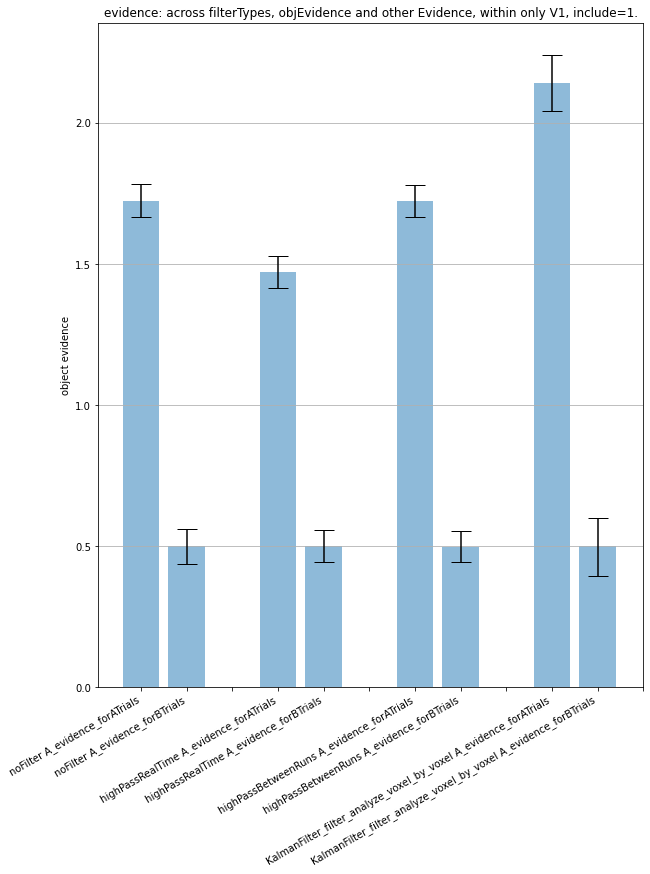

noFilter highPassRealTime p=1.181456232027278e-30
noFilter highPassBetweenRuns p=0.9158023139935332
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=8.77783505850048e-22
highPassRealTime highPassBetweenRuns p=1.6398811154508254e-47
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=1.2546149751453676e-37
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=2.0095917350343338e-19
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


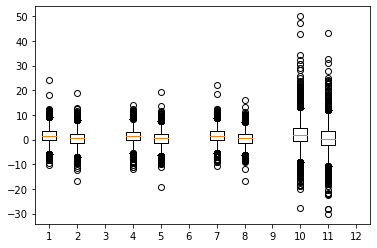

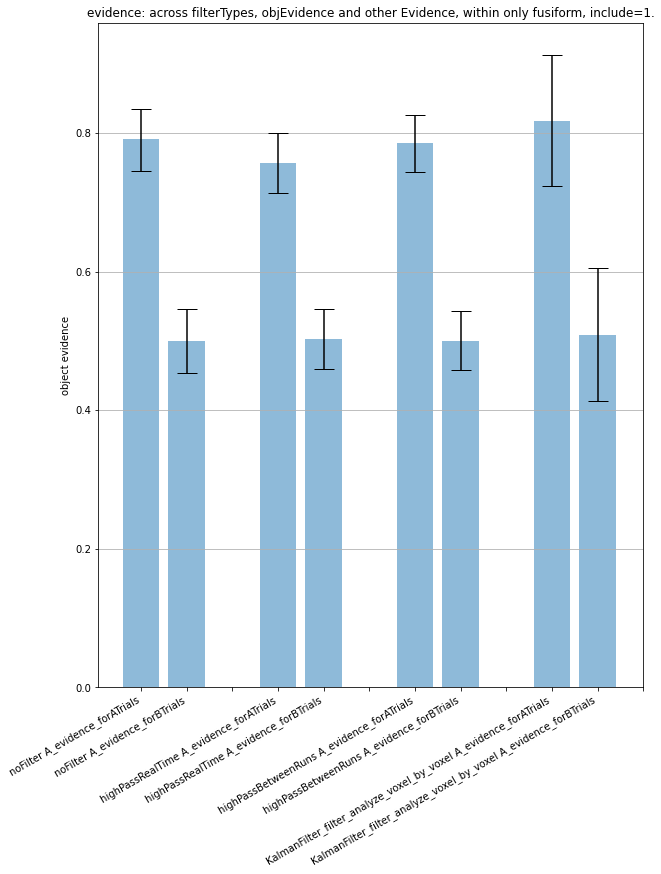

noFilter highPassRealTime p=0.021418594084927137
noFilter highPassBetweenRuns p=0.4907164505455446
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.5482259337828406
highPassRealTime highPassBetweenRuns p=0.012559591130567177
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.21824800215965942
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.47954127863149965
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


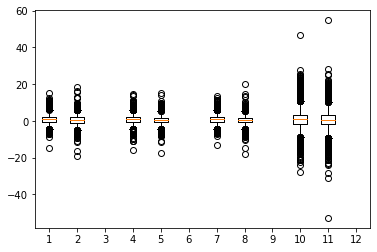

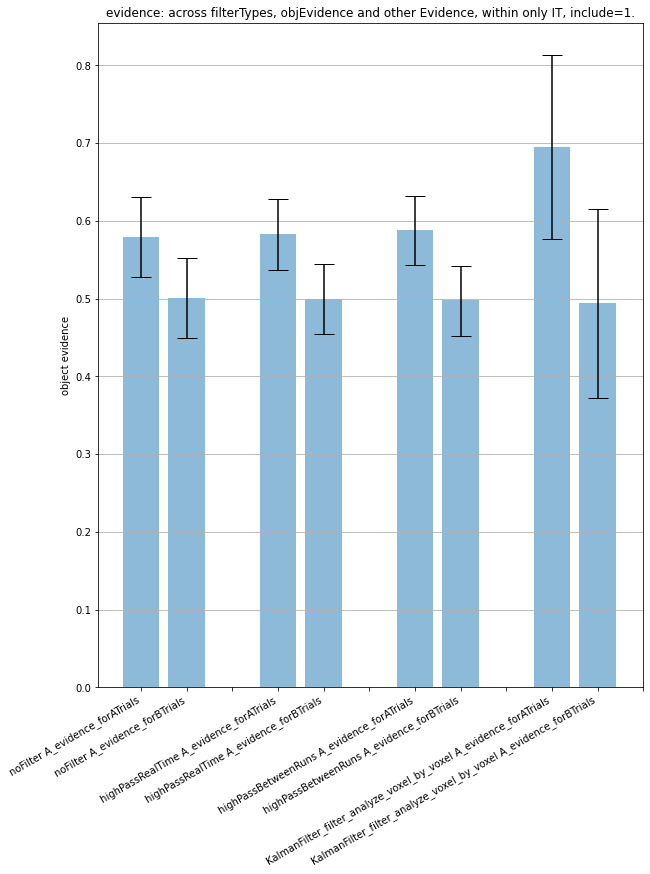

noFilter highPassRealTime p=0.7986555139490932
noFilter highPassBetweenRuns p=0.47944238204697465
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.03599886794039734
highPassRealTime highPassBetweenRuns p=0.7001393347187814
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.07069759722166519
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.07136401625183153
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


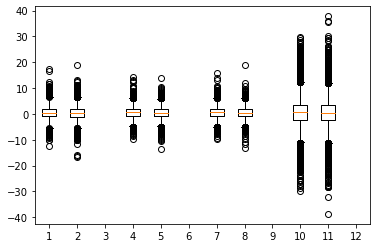

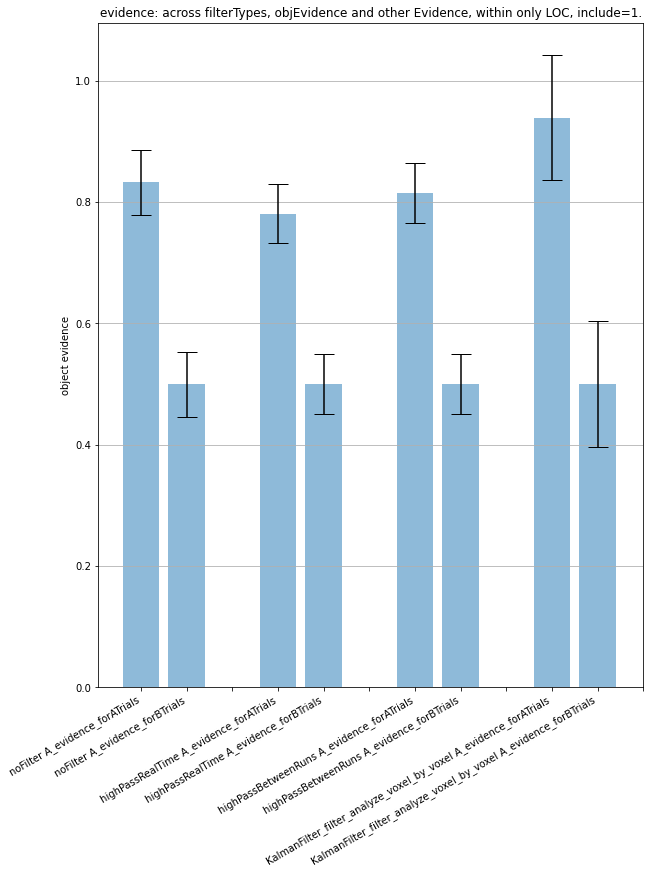

noFilter highPassRealTime p=0.006859823395799171
noFilter highPassBetweenRuns p=0.15954845147535898
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.027865868712079724
highPassRealTime highPassBetweenRuns p=0.009698908220776155
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0031060328828168594
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.014545055587172274
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


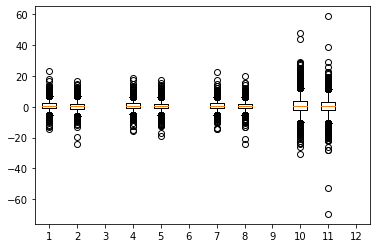

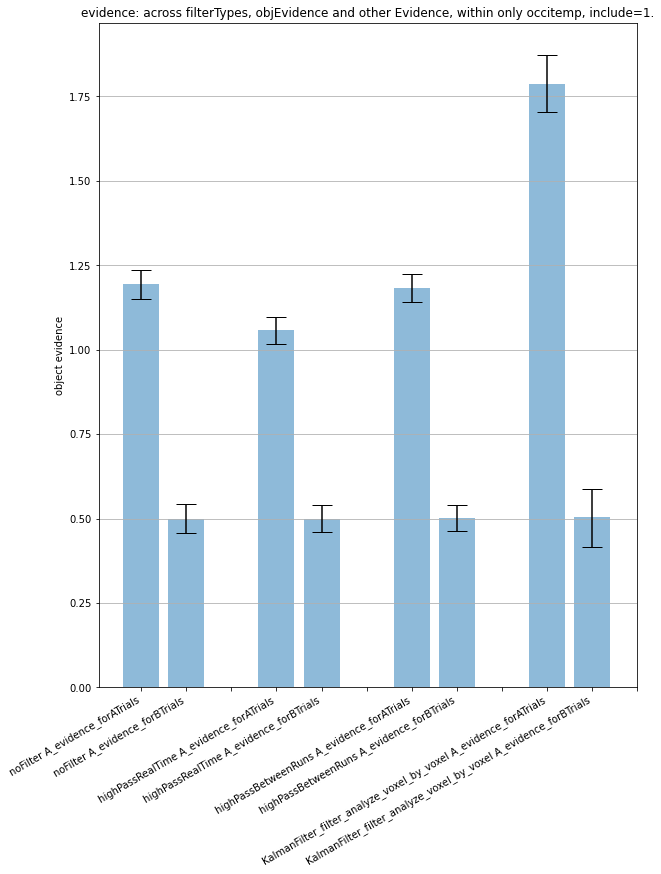

noFilter highPassRealTime p=1.2437580468016307e-19
noFilter highPassBetweenRuns p=0.19924890135110035
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=1.4983976355260818e-57
highPassRealTime highPassBetweenRuns p=1.0504223933268782e-26
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=1.6189709135995727e-64
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=8.45897668973946e-53
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


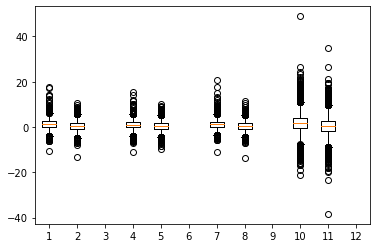

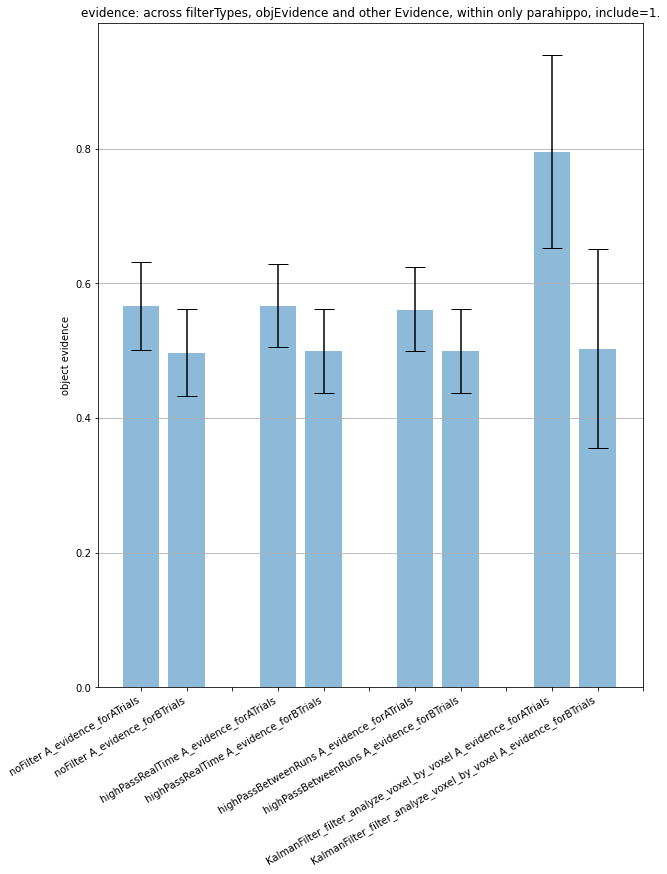

noFilter highPassRealTime p=0.9825894499198438
noFilter highPassBetweenRuns p=0.583997267574931
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.0012750005231872096
highPassRealTime highPassBetweenRuns p=0.6759374764630086
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.002409924871091724
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.0011207762746764682


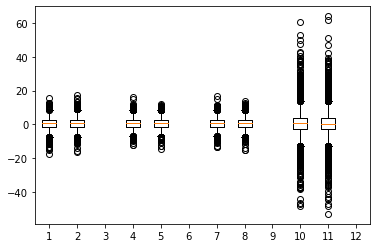

In [18]:
def evidenceAcrossFiltertypes(ROI="V1"):
    # I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
            d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

        a.append(concatArrayArray(c))
        a.append(concatArrayArray(d))
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.')

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")

for i in range(len(ROIs)):
    evidenceAcrossFiltertypes(ROI=ROIs[i])

L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


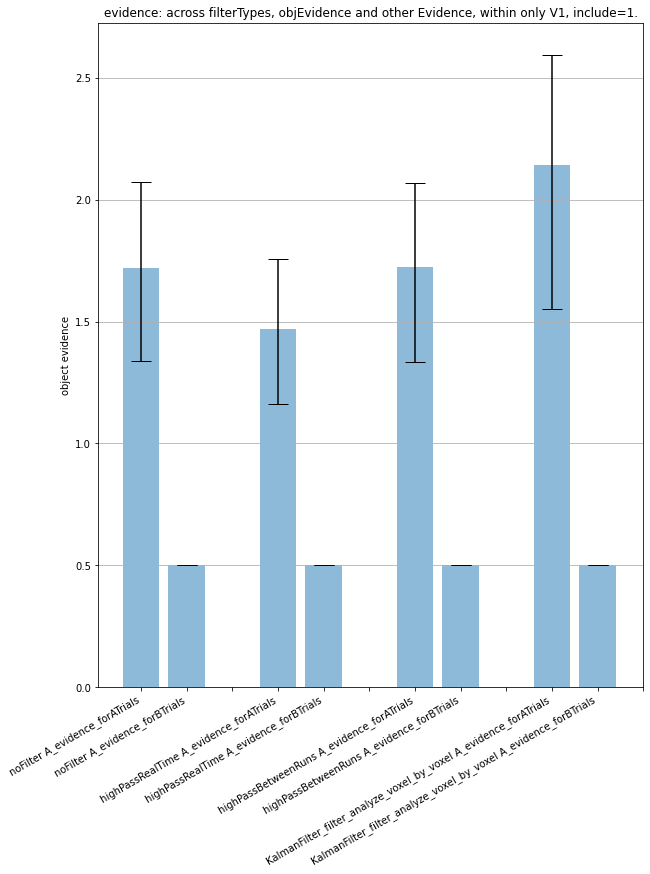

noFilter highPassRealTime p=0.0048609219989227525
noFilter highPassBetweenRuns p=0.8958049097489382
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.007106388201477699
highPassRealTime highPassBetweenRuns p=0.002752344947753163
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.005593434094335825
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.008803911219295368
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


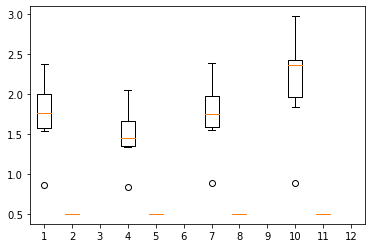

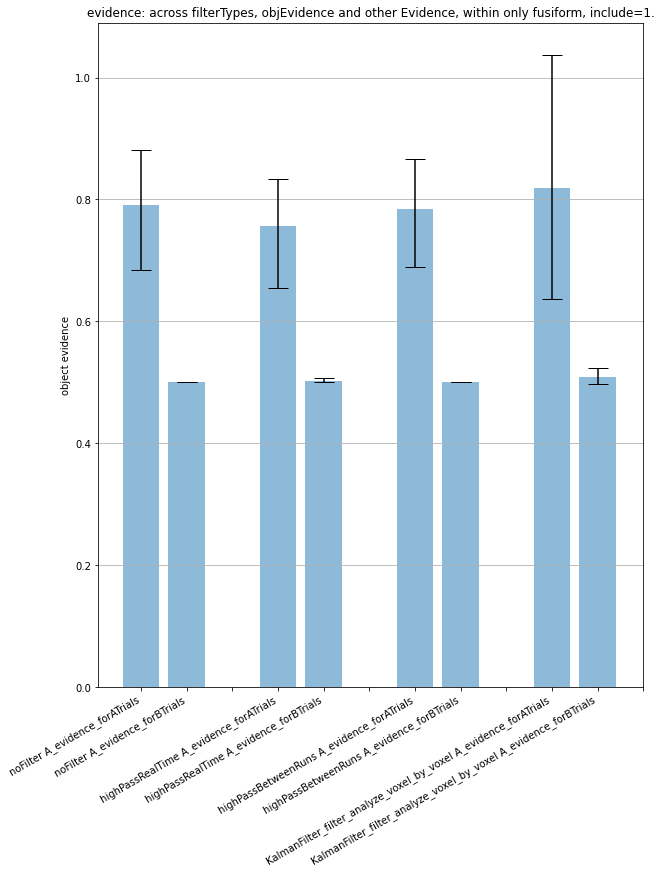

noFilter highPassRealTime p=0.07424803895931442
noFilter highPassBetweenRuns p=0.35204704607736664
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.8133947329799361
highPassRealTime highPassBetweenRuns p=0.07293993817123648
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.6211841047837829
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.7771154735377515
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


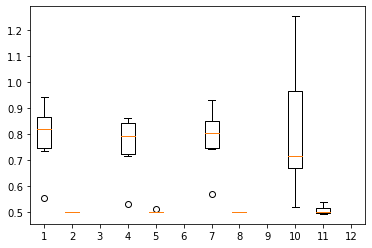

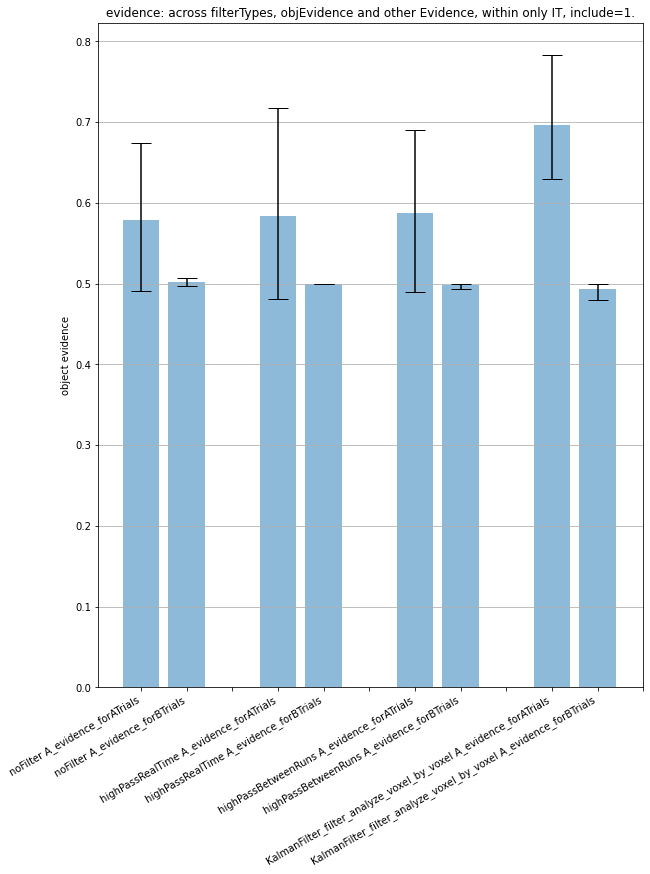

noFilter highPassRealTime p=0.8651773127265673
noFilter highPassBetweenRuns p=0.4213008179831088
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.04184814757875965
highPassRealTime highPassBetweenRuns p=0.8050837031688766
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.03767228326873734
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.04098797238764722
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


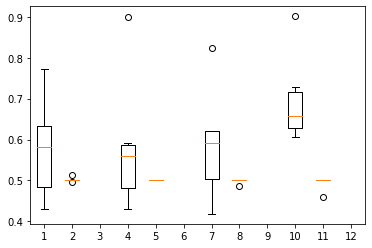

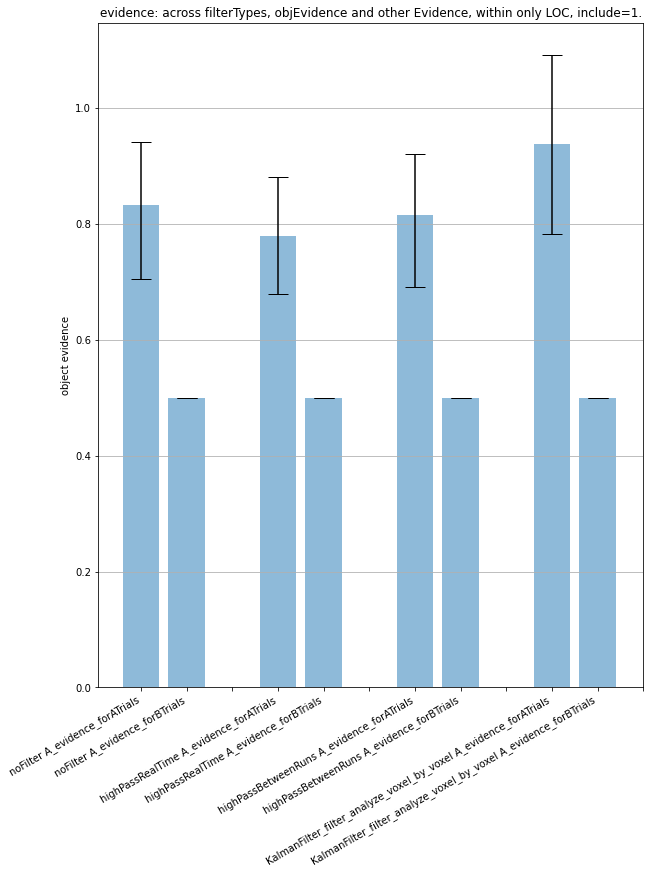

noFilter highPassRealTime p=0.07716893052913296
noFilter highPassBetweenRuns p=0.05962145917389137
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.05672337826087486
highPassRealTime highPassBetweenRuns p=0.18760493700853054
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.012573760533625264
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.04722848653387947
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


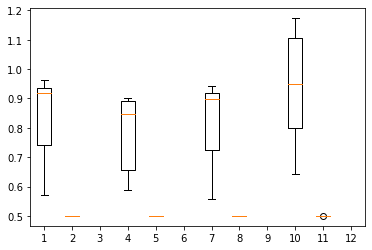

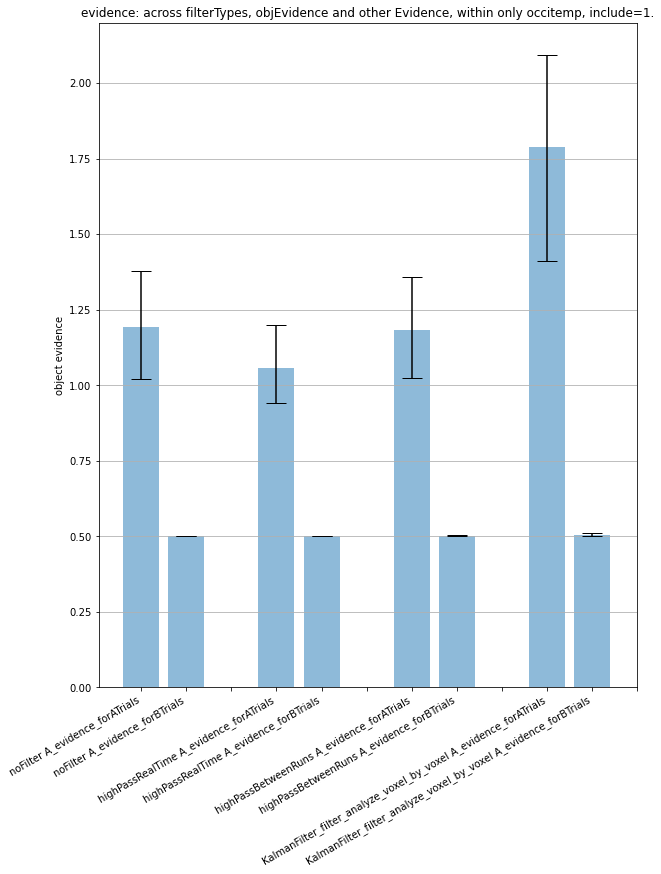

noFilter highPassRealTime p=0.009075886779589194
noFilter highPassBetweenRuns p=0.10494143007710369
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.0026792371336060465
highPassRealTime highPassBetweenRuns p=0.006163716536325032
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0032433908042608095
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.0030180952486832872
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


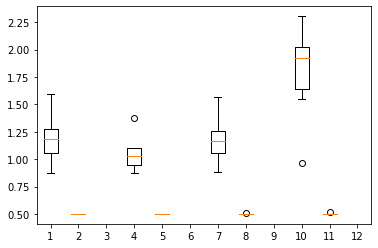

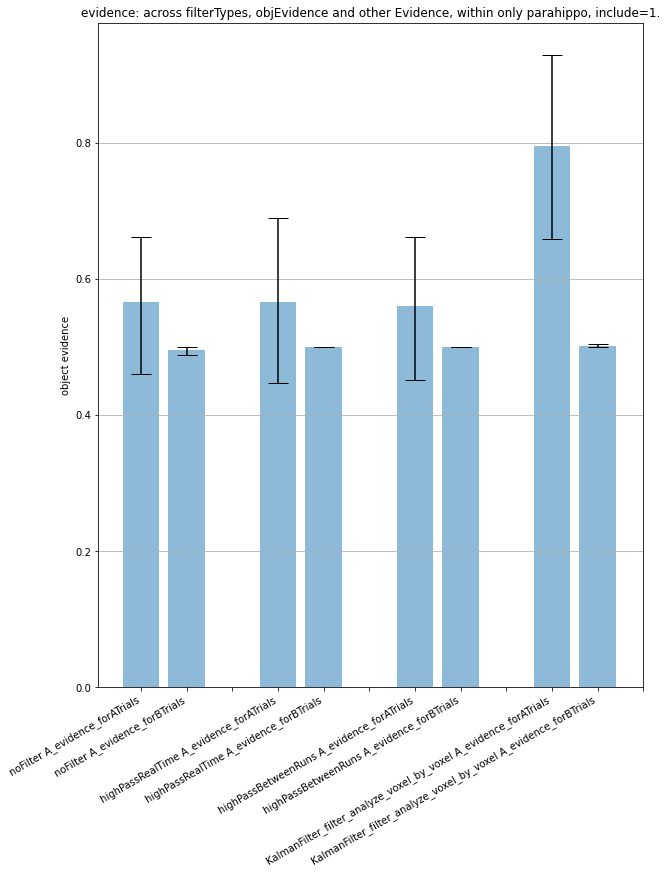

noFilter highPassRealTime p=0.9907718168131827
noFilter highPassBetweenRuns p=0.8186988809874636
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.002080508233088042
highPassRealTime highPassBetweenRuns p=0.8011439719727526
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0020618986036828363
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.00019041935499636238


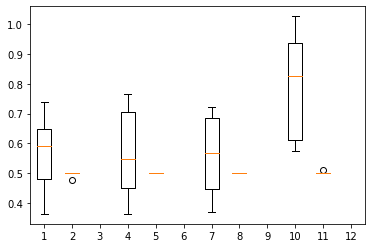

In [19]:
def evidenceAcrossFiltertypes_meanForSub(ROI="V1"):
    # across filterType, take the difference between objEvidence and other Evidence, within only V1, include=1.
    filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']

    # I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials'])))) #conbine the data together
            d.append(np.nanmean(np.asarray(list(t['A_evidence_forBTrials']))))

        a.append(c)
        a.append(d)
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.')

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")

for i in range(len(ROIs)):
    evidenceAcrossFiltertypes_meanForSub(ROI=ROIs[i])

100%|██████████| 6/6 [00:00<00:00, 104.72it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


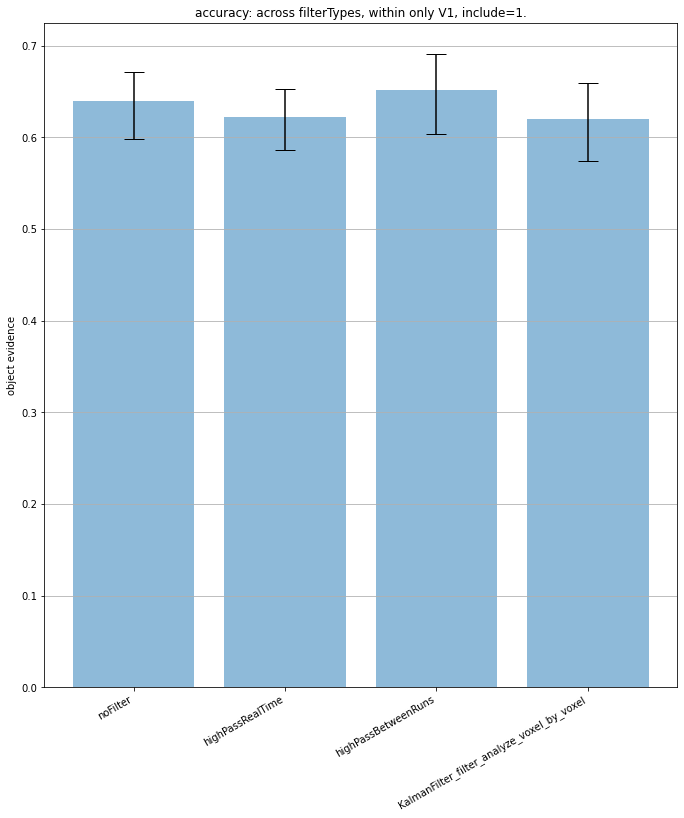

  0%|          | 0/6 [00:00<?, ?it/s]

noFilter highPassRealTime p=0.016727865250657524
noFilter highPassBetweenRuns p=0.069569968296266
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.009696048802806043
highPassRealTime highPassBetweenRuns p=0.0069421764593900915
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.8304770311068497
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.00028202946525278345


100%|██████████| 6/6 [00:00<00:00, 102.40it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


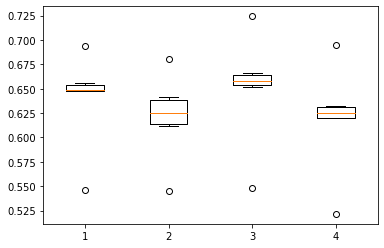

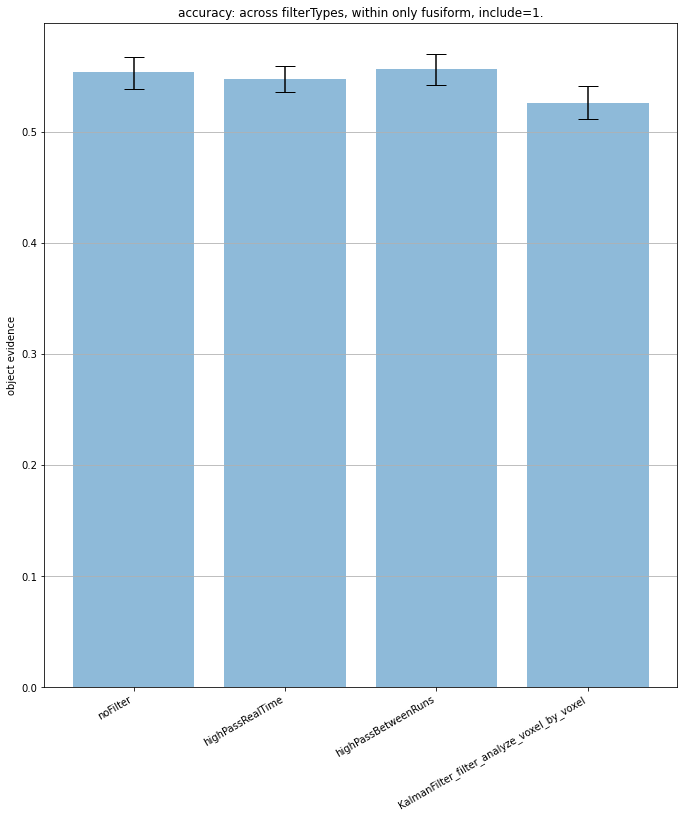

  0%|          | 0/6 [00:00<?, ?it/s]

noFilter highPassRealTime p=0.2654874750173405
noFilter highPassBetweenRuns p=0.6468408856783507
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.04817903990144435
highPassRealTime highPassBetweenRuns p=0.21551850997098382
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.14979047534434556
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.046923115488218245


100%|██████████| 6/6 [00:00<00:00, 90.49it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


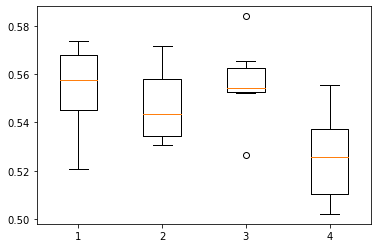

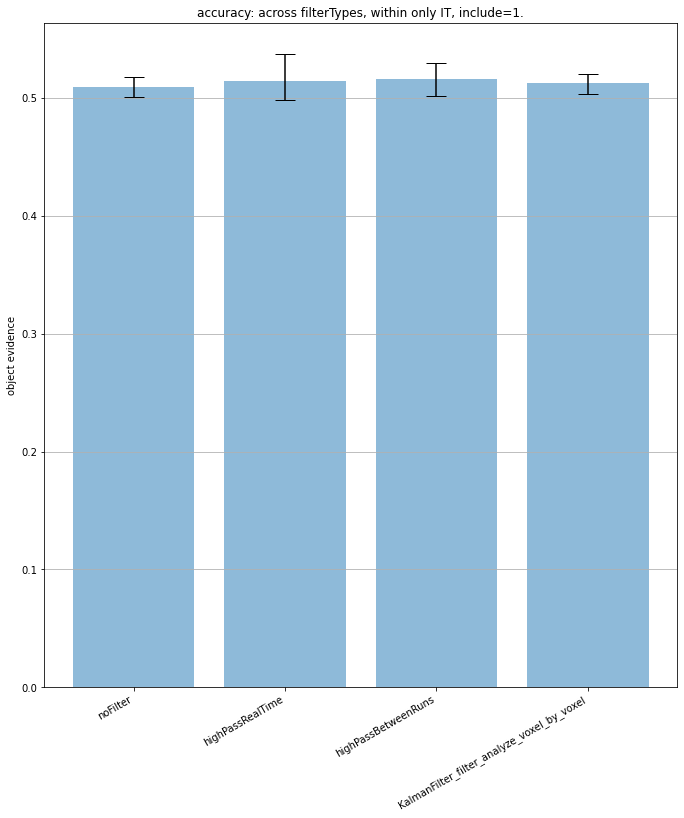

  0%|          | 0/6 [00:00<?, ?it/s]

noFilter highPassRealTime p=0.5771752872756586
noFilter highPassBetweenRuns p=0.18202084481210712
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.643852479753799
highPassRealTime highPassBetweenRuns p=0.7470647508267065
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.9041030959886865
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.7453411349736523


100%|██████████| 6/6 [00:00<00:00, 103.28it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


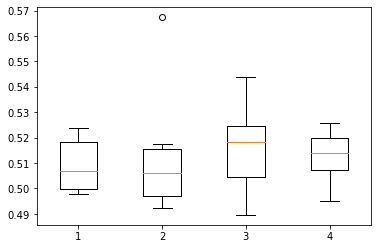

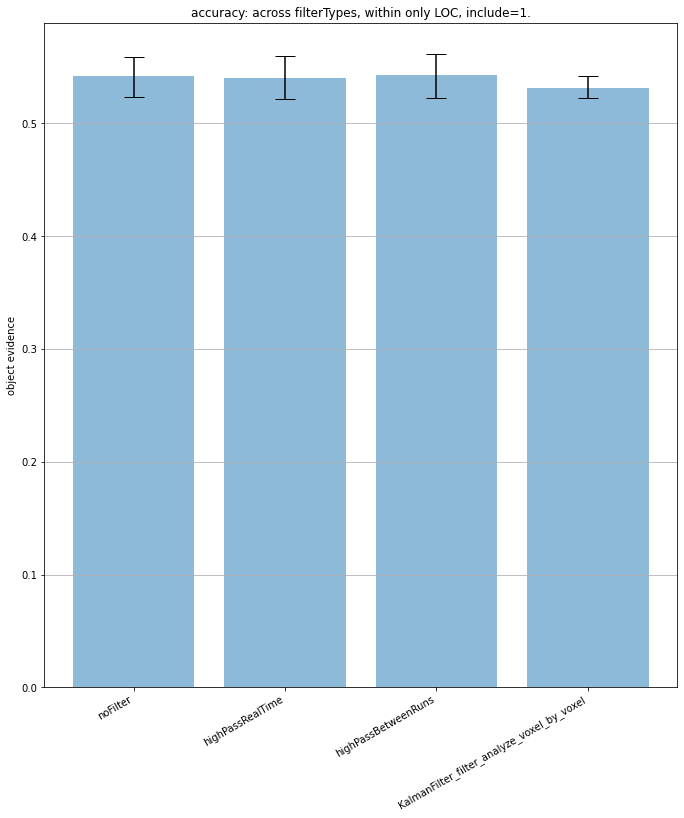

  0%|          | 0/6 [00:00<?, ?it/s]

noFilter highPassRealTime p=0.6974517774018894
noFilter highPassBetweenRuns p=0.9043483955332964
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.20469339392585628
highPassRealTime highPassBetweenRuns p=0.6495419499467112
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.37502333095737617
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.20076206182744638


100%|██████████| 6/6 [00:00<00:00, 93.17it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


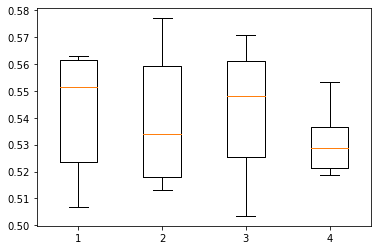

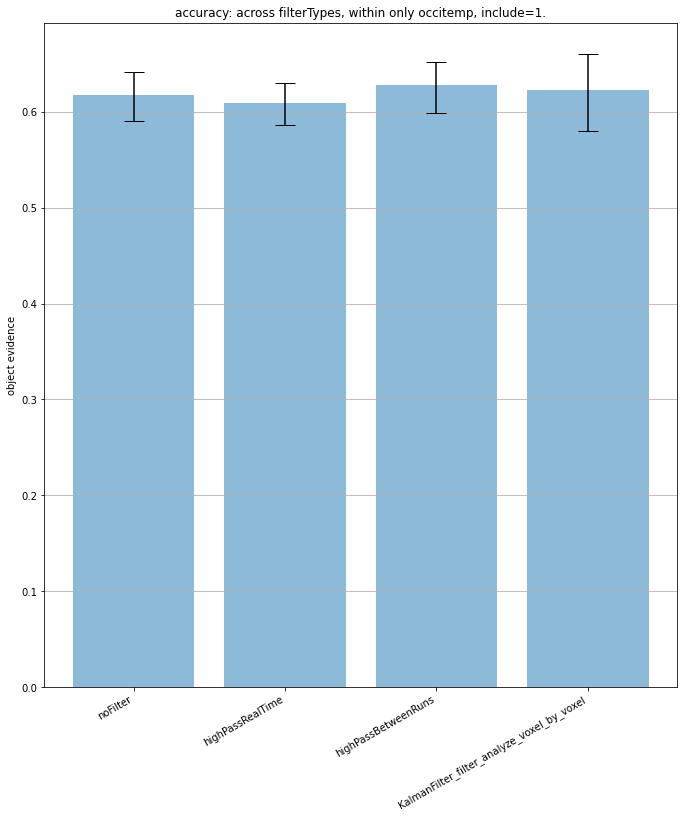

  0%|          | 0/6 [00:00<?, ?it/s]

noFilter highPassRealTime p=0.1668177336041552
noFilter highPassBetweenRuns p=0.0359838309729141
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.7081345076115534
highPassRealTime highPassBetweenRuns p=0.0026583796234261638
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.4228674142933023
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.772945929188784


100%|██████████| 6/6 [00:00<00:00, 102.90it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


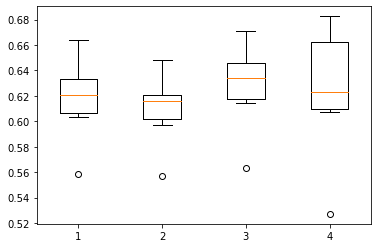

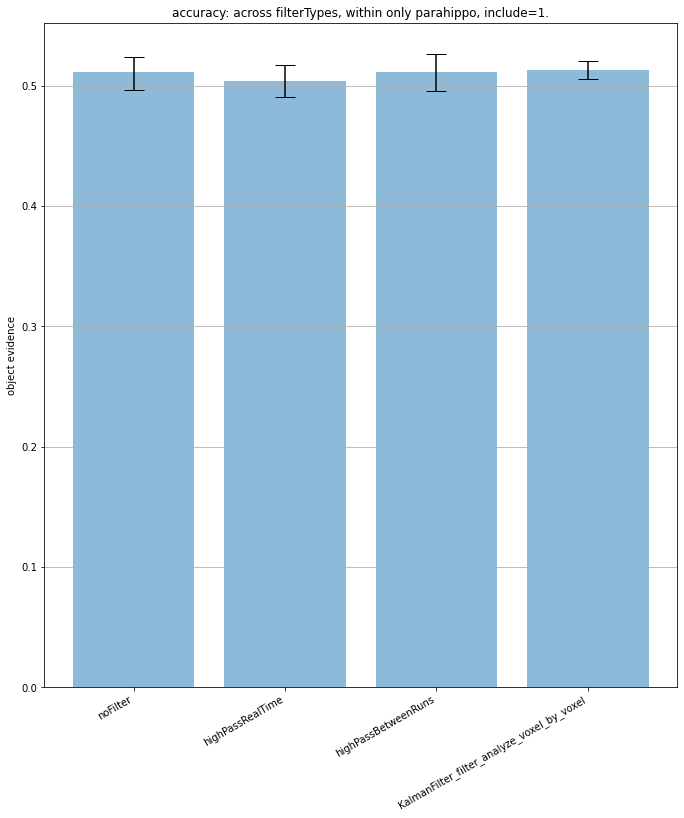

noFilter highPassRealTime p=0.1379341101755902
noFilter highPassBetweenRuns p=0.9420768600492023
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.7508316968105981
highPassRealTime highPassBetweenRuns p=0.08644627722841888
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.251995456081534
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.7980453273598711


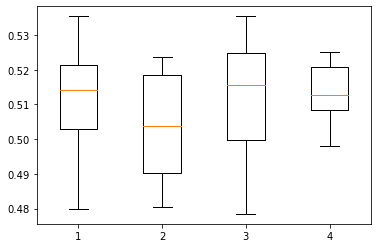

In [20]:
def accuracyAcrossFiltertype(ROI="V1"):
    # accuracy: across filterType, take subject mean, within only V1, include=1.

    # I want to construction a list whose 1st element is the accuracy for noFilter, 2nd for highpass and so on.
    # each element is 32 numbers for 32 subjects. each number is the mean accuracy for that subject.
    a=[]
    for i in range(len(filterTypes)):
        b=[]
        for sub in tqdm(subjects):
            try:
                b.append(np.mean(accuracyContainer[
                        _and_([
                            accuracyContainer['roi']==ROI, 
                            accuracyContainer['filterType']==filterTypes[i],
                            accuracyContainer['sub']==int(sub),
                            accuracyContainer['include']==1.
                        ])]['acc']))
            except:
                pass
        a.append(np.asarray(b))
    bar(a,labels=list(filterTypes),title=f'accuracy: across filterTypes, within only {ROI}, include=1.')
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # paired ttest
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i],a[j])[1]}")

for i in range(len(ROIs)):
    accuracyAcrossFiltertype(ROI=ROIs[i])

100%|██████████| 6/6 [00:00<00:00, 105.00it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


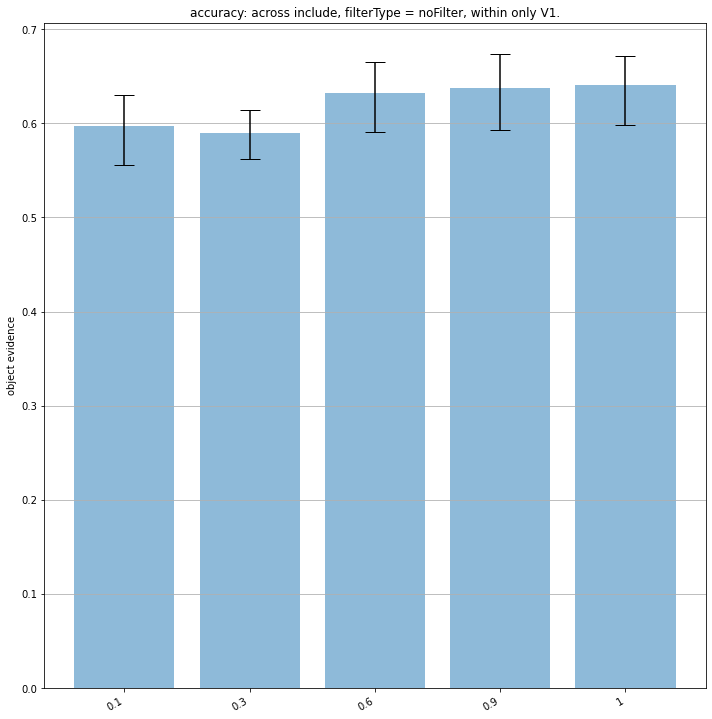

100%|██████████| 6/6 [00:00<00:00, 105.37it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


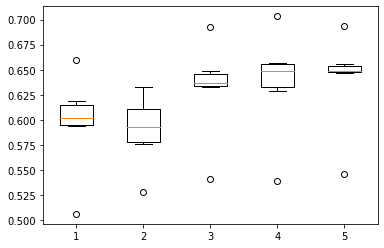

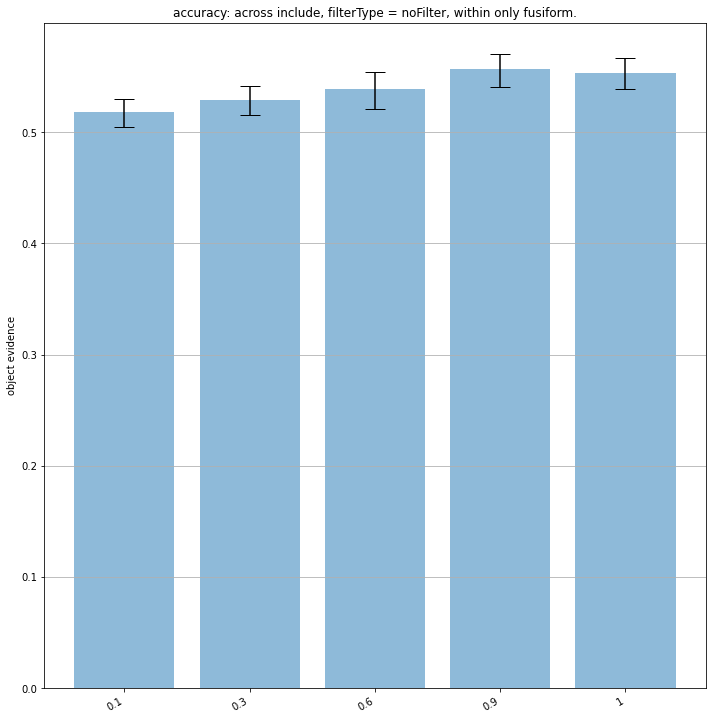

100%|██████████| 6/6 [00:00<00:00, 105.27it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


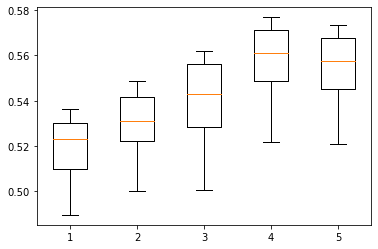

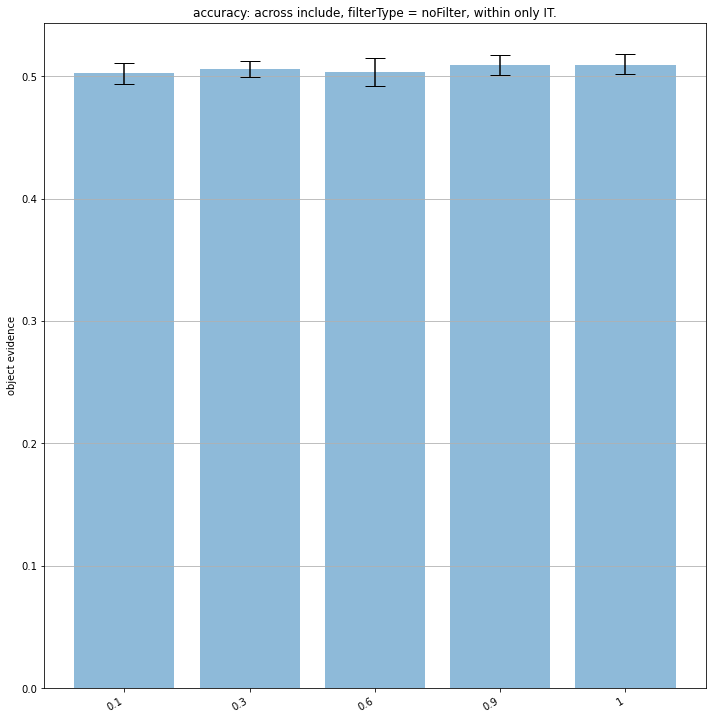

100%|██████████| 6/6 [00:00<00:00, 106.40it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


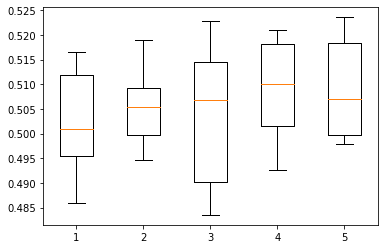

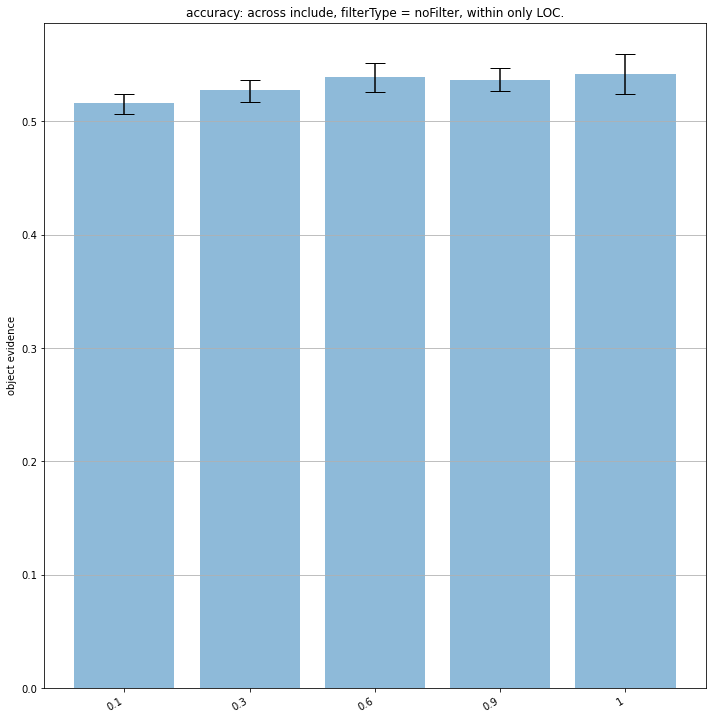

100%|██████████| 6/6 [00:00<00:00, 105.22it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


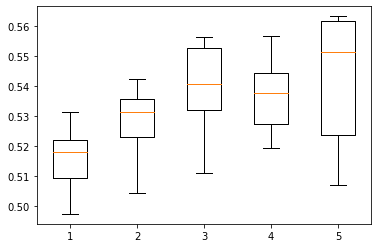

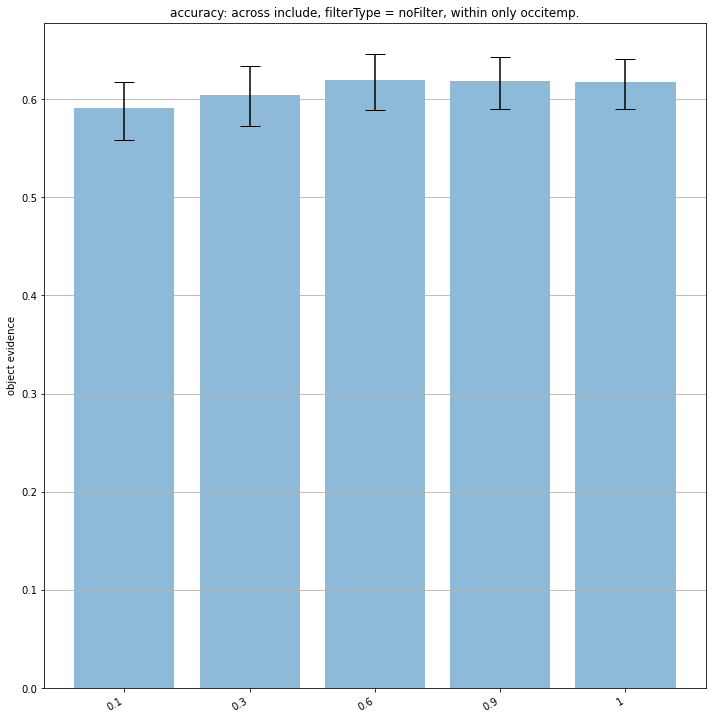

100%|██████████| 6/6 [00:00<00:00, 106.45it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


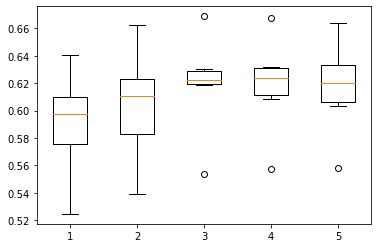

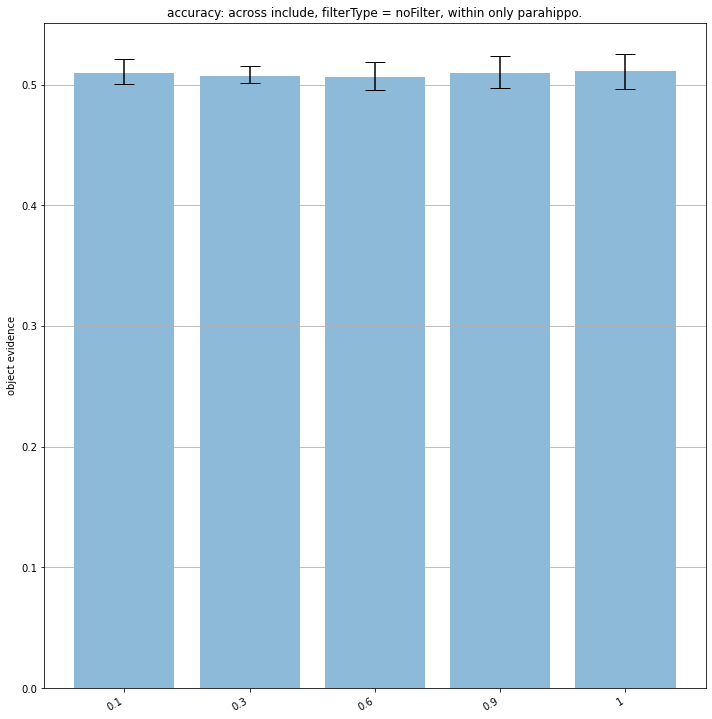

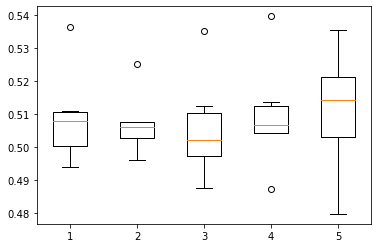

In [21]:
def accuracyIncludes(ROI="V1"):
    # compare between includes using accuracy
    # I want to construct a comparison between different includes by having includes
    includes=[0.1,0.3,0.6,0.9,1]
    filterType='noFilter'
    a=[]
    for include in includes:
        b=[]
        for sub in tqdm(subjects):
            try:
                b.append(np.mean(accuracyContainer[
                        _and_([
                            accuracyContainer['roi']==ROI, 
                            accuracyContainer['filterType']==filterType,
                            accuracyContainer['sub']==int(sub),
                            accuracyContainer['include']==np.float(include)
                        ])]['acc']))
            except:
                pass
        a.append(np.asarray(b))
    bar(a,labels=list(includes),title=f'accuracy: across include, filterType = {filterType}, within only {ROI}.')
    _=plt.figure()
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

for i in range(len(ROIs)):
    accuracyIncludes(ROI=ROIs[i])

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


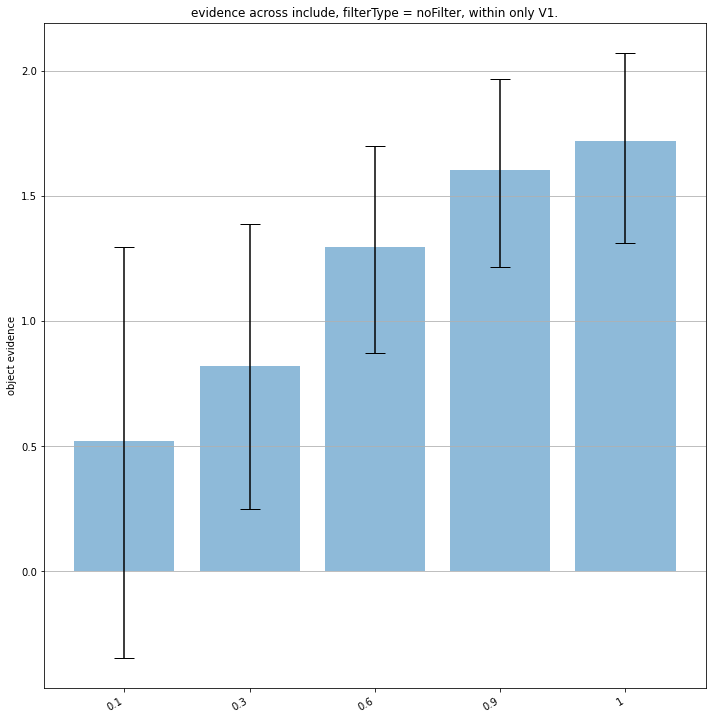

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


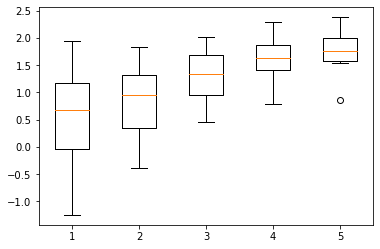

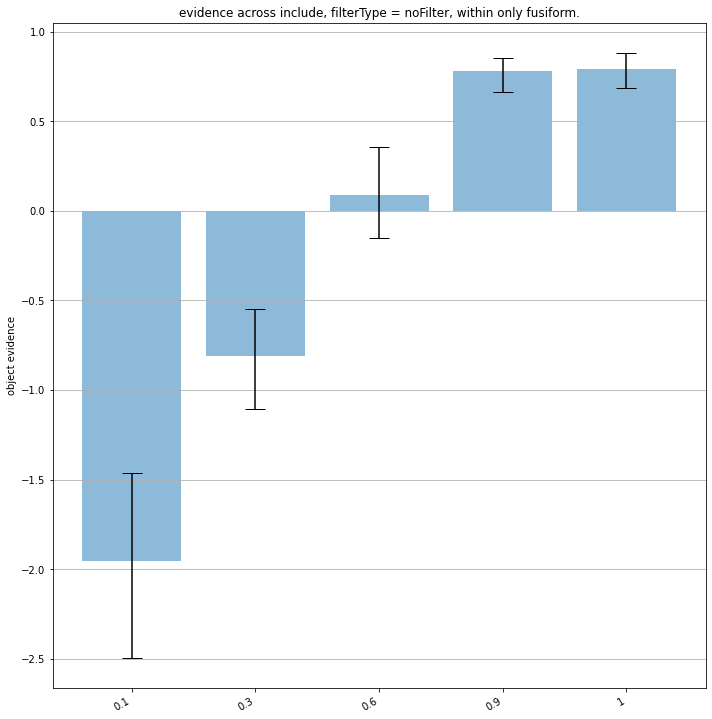

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


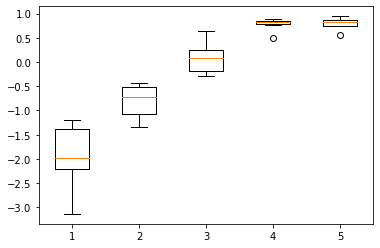

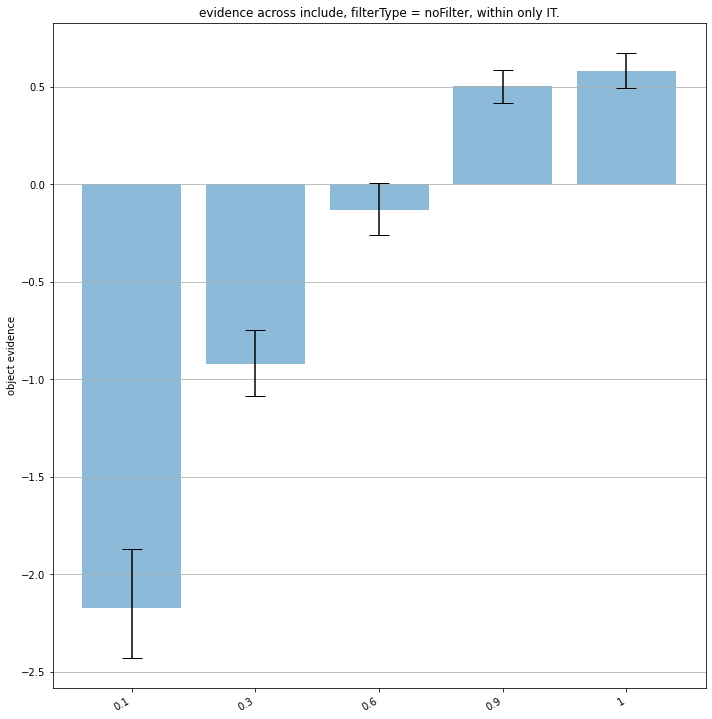

100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


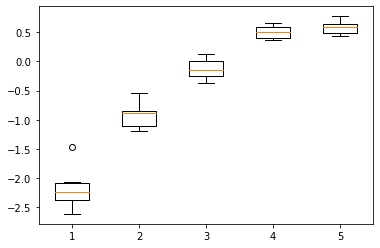

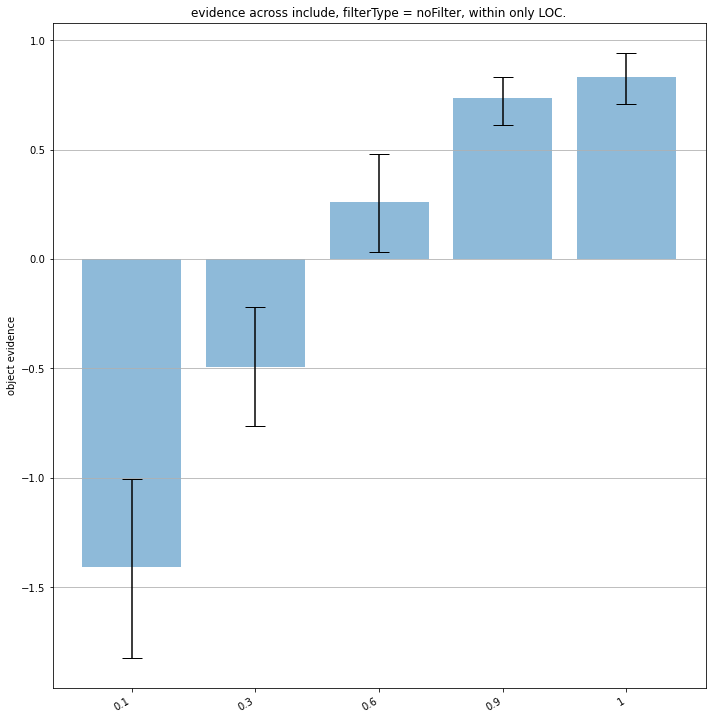

100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


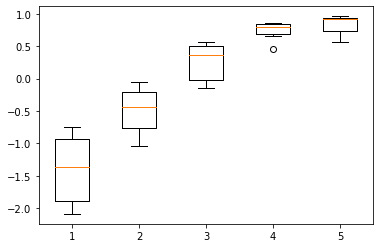

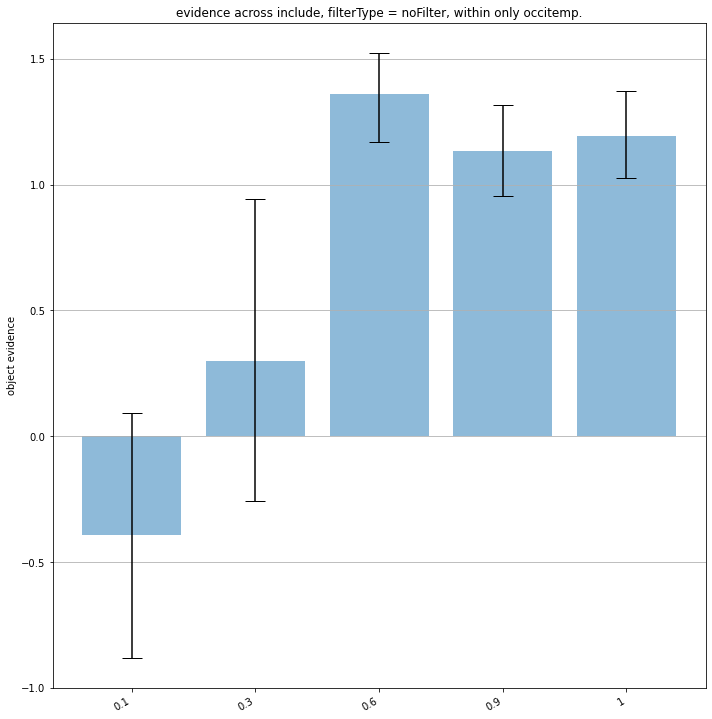

100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


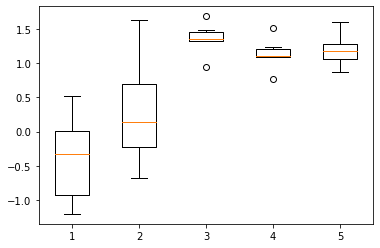

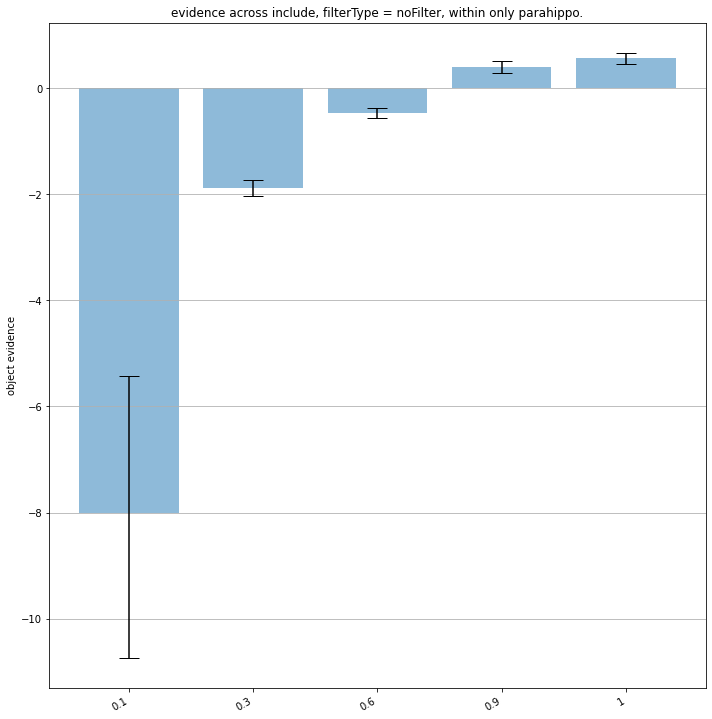

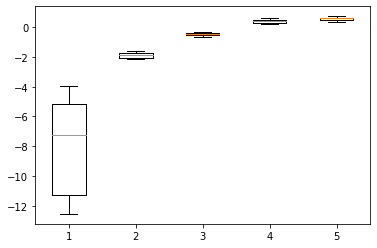

In [22]:
def evidenceIncludes(ROI="V1"): # filtering the features would often increase the performance.
    # compare between includes using evidence
    # I want to construct a comparison between different includes by having includes
    includes=[0.1,0.3,0.6,0.9,1]
    filterType='noFilter'
    a=[]
    for include in includes:
        b=[]
        for sub in tqdm(subjects):
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterType,
                testEvidence['include']==np.float(include),
                testEvidence['sub']==int(sub)
            ])]
            t=preloadDfnumpy(t)
            b.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials']))))
        a.append(np.asarray(b))
    bar(a,labels=list(includes),title=f'evidence across include, filterType = {filterType}, within only {ROI}.')
    _=plt.figure()
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

for i in range(len(ROIs)):
    evidenceIncludes(ROI=ROIs[i])

In [ ]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    return 

heights = [1.8, 2, 3]
bars = np.arange(len(heights))
plt.figure()
plt.bar(bars, heights, align='center')
plt.ylim(0, 5)

barplot_annotate_brackets(0, 1, .1, bars, heights)
barplot_annotate_brackets(1, 2, .001, bars, heights)
barplot_annotate_brackets(0, 2, 'p < 0.0075', bars, heights, dh=.2)

L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


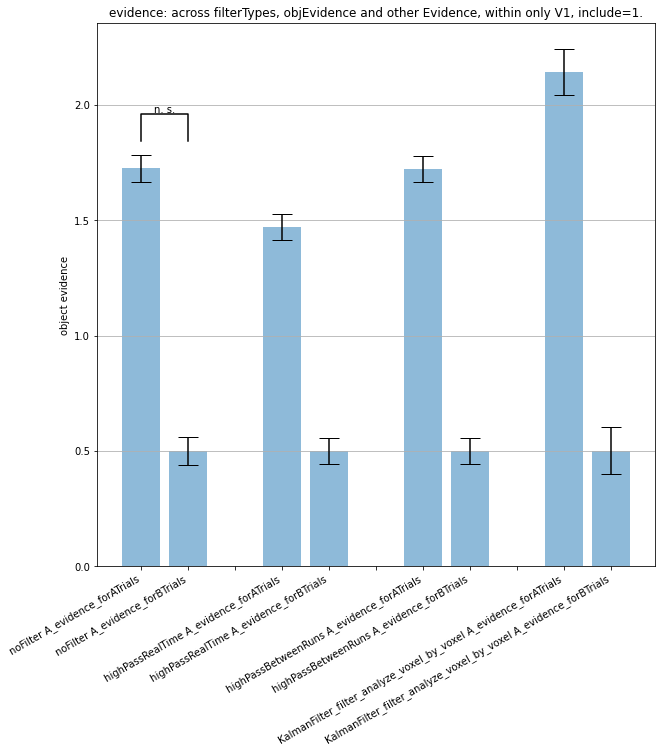

In [37]:
def bar(LL,labels=None,title=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    # plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    barplot_annotate_brackets(0, 1, .1, np.arange(len(m)), m,ax=ax)
#     plt.show()
    return m,lower,upper,ax
m,lower,upper,ax=bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.')
# barplot_annotate_brackets(0, 1, .1, np.arange(len(m)), m)

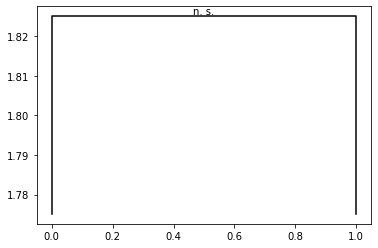

In [36]:
def barplot_annotate_brackets(num1, num2, data, center, height, ax=ax,yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    return 
barplot_annotate_brackets(0, 1, .1, np.arange(len(m)), m,ax=ax)

plt.show()

noFilter highPassRealTime p=1.181456232027278e-30
noFilter highPassBetweenRuns p=0.9158023139935332
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=8.77783505850048e-22
highPassRealTime highPassBetweenRuns p=1.6398811154508254e-47
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=1.2546149751453676e-37
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=2.0095917350343338e-19
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


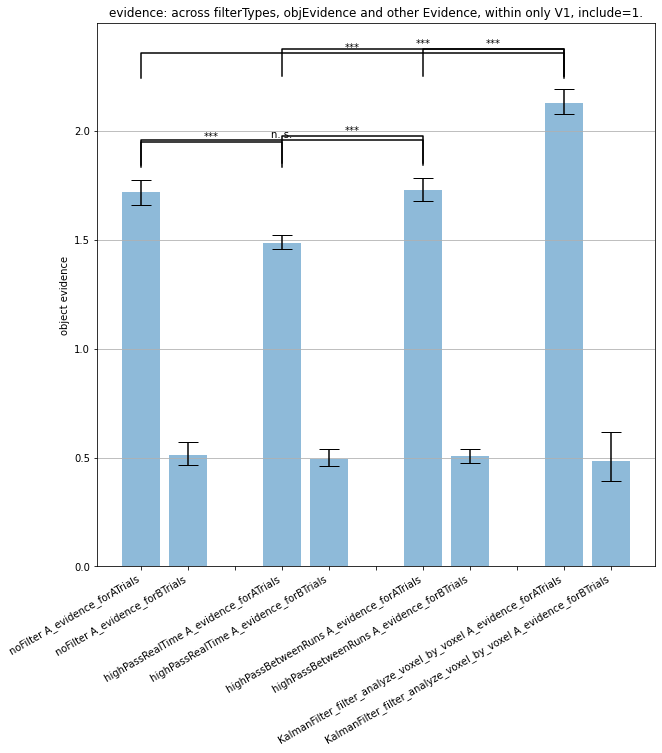

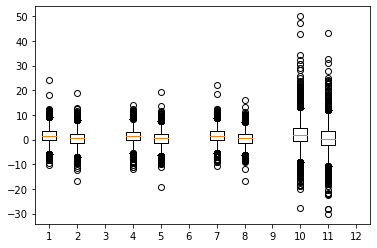

In [43]:
def barplot_annotate_brackets(num1, num2, data, center, height, ax=ax,yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            if len(text)>=3:
                break
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    return 
def resample(L):
    L=np.asarray(L).reshape(-1)
    print('L.shape=',L.shape)
    sample_mean=[]
    for iter in range(10):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m
def bar(LL,labels=None,title=None,pairs=None,pvalue=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    # plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    if pairs!=None:
        for pair in pairs:
            barplot_annotate_brackets(pair[0], pair[1], pvalue[pair], x_pos, m)
    plt.show()
    return m,lower,upper,ax


ROI="V1"
# I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
# for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
a=[]
labels=[]
for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
    c=[]
    d=[]

    # to get one single number for A_evidence_forATrials for each subject. 
    # you will need to extract the corresponding conditions and conbine the data together. 
    for sub in subjects:
        t=testEvidence[_and_([ #extract
            testEvidence['roi']==ROI,
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==sub
        ])]
        t=preloadDfnumpy(t)

        c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
        d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

    a.append(concatArrayArray(c))
    a.append(concatArrayArray(d))
    a.append([])
    labels.append(filterTypes[i] + ' A_evidence_forATrials')
    labels.append(filterTypes[i] + ' A_evidence_forBTrials')
    labels.append('')

# paired t-test
objects=np.arange(4)
allpairs = itertools.combinations(objects,2)
pvalue={}
pairs=[]
for pair in allpairs:
    i=pair[0]
    j=pair[1]
    print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
    pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
    pairs.append((i*3,j*3))

bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)

e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
_=plt.boxplot(e)


len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=1.181456232027278e-30
noFilter highPassBetweenRuns p=0.9158023139935332
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=8.77783505850048e-22
highPassRealTime highPassBetweenRuns p=1.6398811154508254e-47
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=1.2546149751453676e-37
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=2.0095917350343338e-19
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


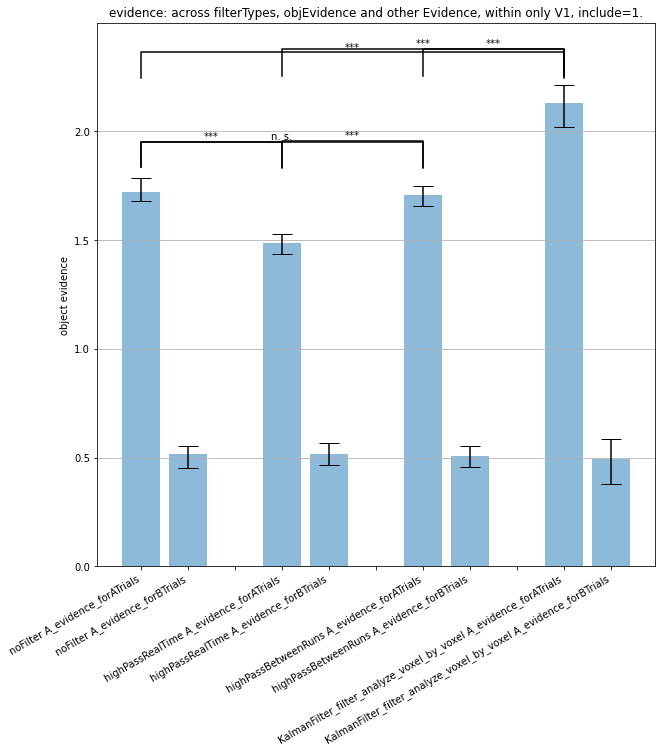

len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=0.021418594084927137
noFilter highPassBetweenRuns p=0.4907164505455446
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.5482259337828406
highPassRealTime highPassBetweenRuns p=0.012559591130567177
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.21824800215965942
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.47954127863149965
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


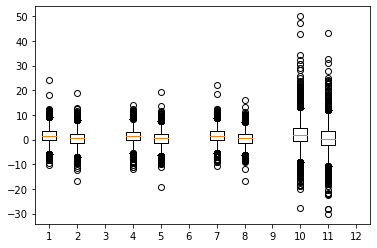

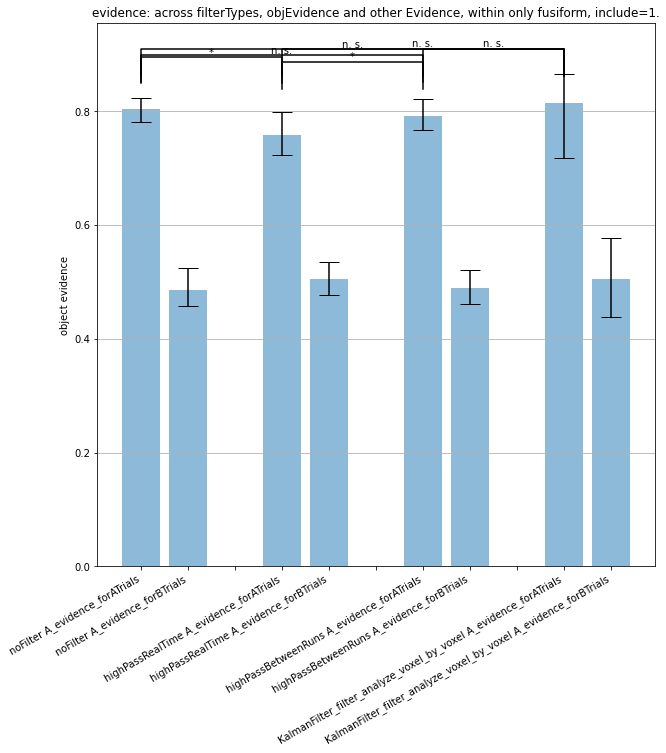

len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=0.7986555139490932
noFilter highPassBetweenRuns p=0.47944238204697465
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.03599886794039734
highPassRealTime highPassBetweenRuns p=0.7001393347187814
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.07069759722166519
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.07136401625183153
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


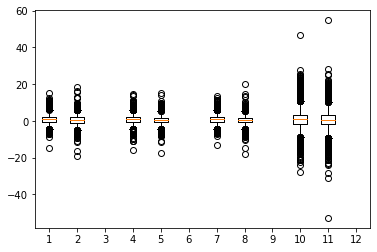

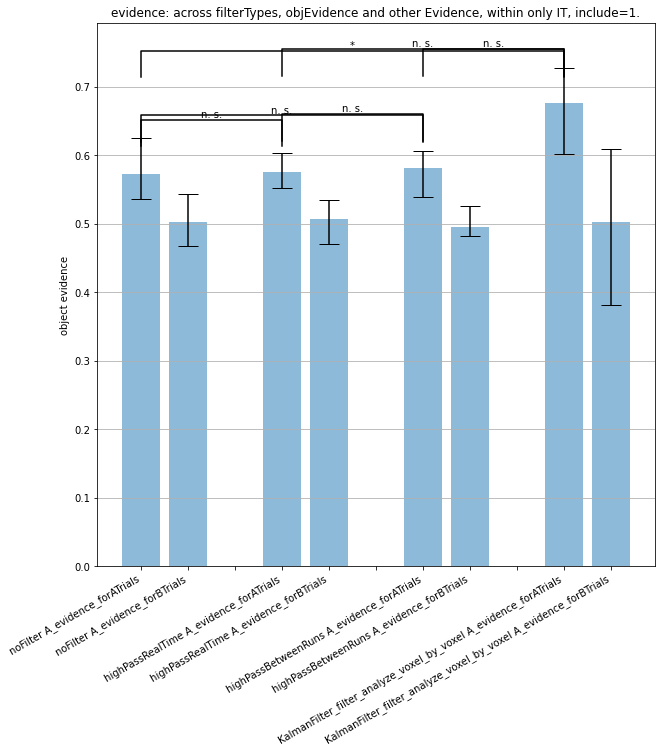

len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=0.006859823395799171
noFilter highPassBetweenRuns p=0.15954845147535898
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.027865868712079724
highPassRealTime highPassBetweenRuns p=0.009698908220776155
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0031060328828168594
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.014545055587172274
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


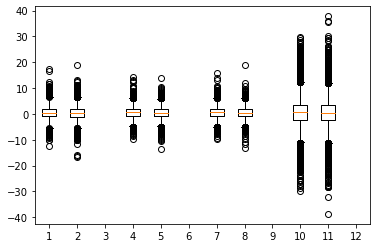

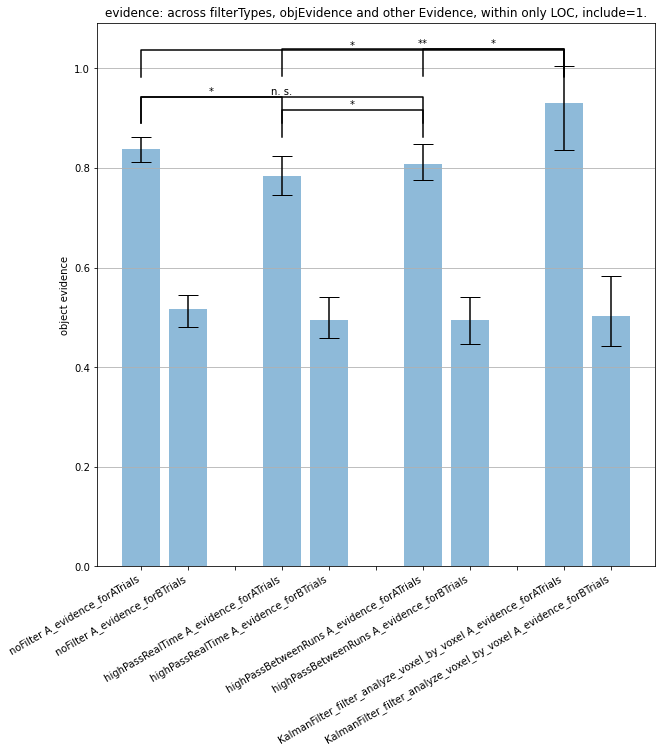

len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=1.2437580468016307e-19
noFilter highPassBetweenRuns p=0.19924890135110035
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=1.4983976355260818e-57
highPassRealTime highPassBetweenRuns p=1.0504223933268782e-26
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=1.6189709135995727e-64
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=8.45897668973946e-53
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


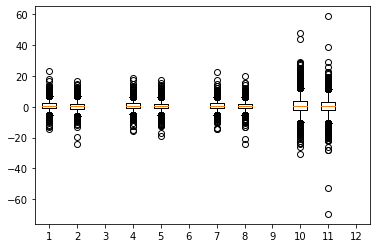

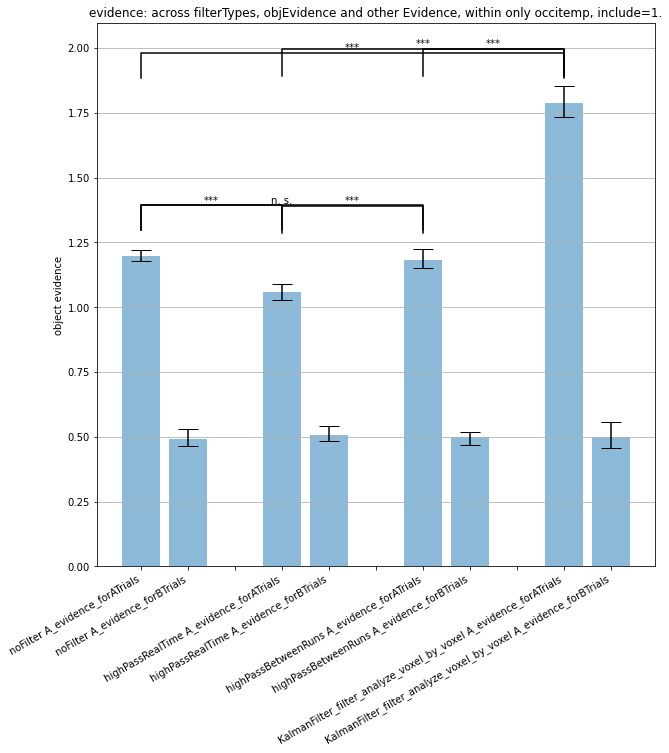

len of a= [8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0, 8640, 8640, 0]
noFilter highPassRealTime p=0.9825894499198438
noFilter highPassBetweenRuns p=0.583997267574931
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.0012750005231872096
highPassRealTime highPassBetweenRuns p=0.6759374764630086
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.002409924871091724
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.0011207762746764682
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)
L.shape= (8640,)
L.shape= (8640,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


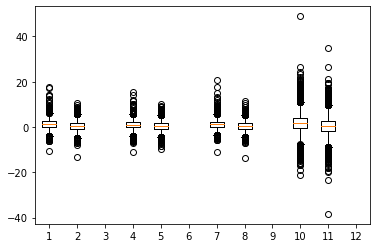

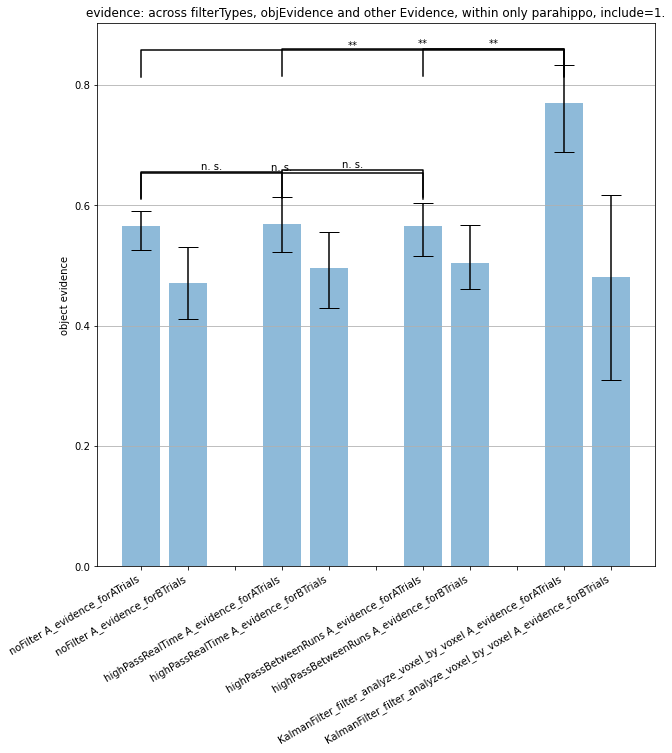

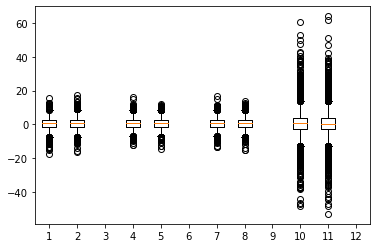

In [52]:
def evidenceAcrossFiltertypes(ROI="V1"):
    # construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
            d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

        a.append(concatArrayArray(c))
        a.append(concatArrayArray(d))
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    print('len of a=',[len(i) for i in a])
    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
        pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
        pairs.append((i*3,j*3))

    bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

for i in range(len(ROIs)):
    evidenceAcrossFiltertypes(ROI=ROIs[i])

len of a =  [6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6, 0]
noFilter highPassRealTime p=0.0048609219989227525
noFilter highPassBetweenRuns p=0.8958049097489382
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.007106388201477699
highPassRealTime highPassBetweenRuns p=0.002752344947753163
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.005593434094335825
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.008803911219295368
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


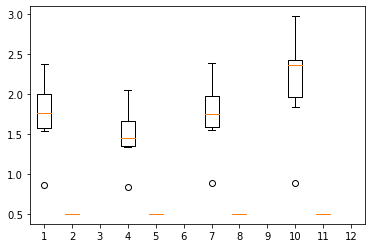

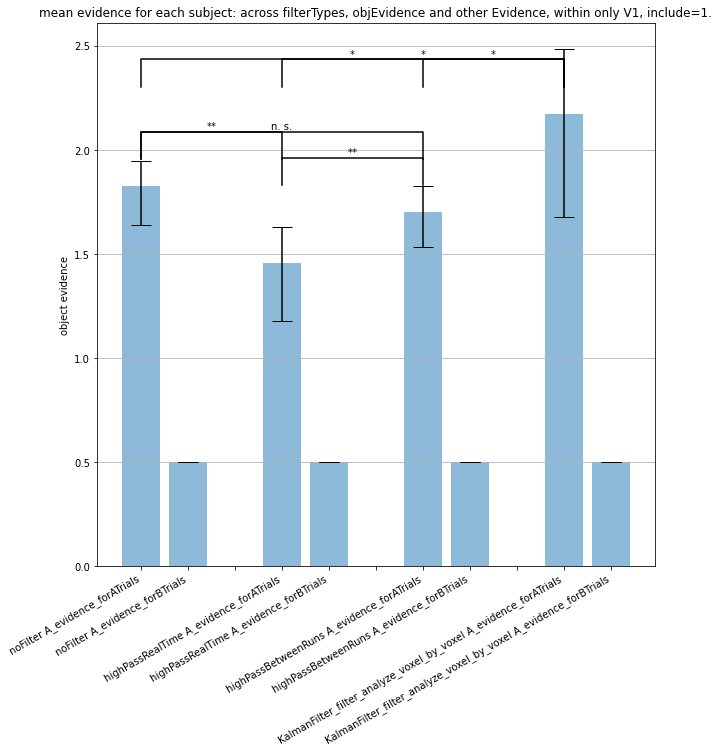

len of a =  [6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6, 0]
noFilter highPassRealTime p=0.07424803895931442
noFilter highPassBetweenRuns p=0.35204704607736664
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.8133947329799361
highPassRealTime highPassBetweenRuns p=0.07293993817123648
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.6211841047837829
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.7771154735377515
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


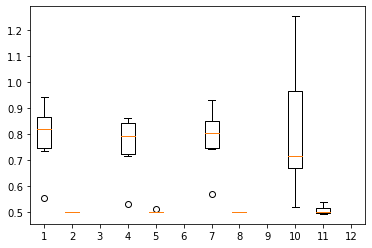

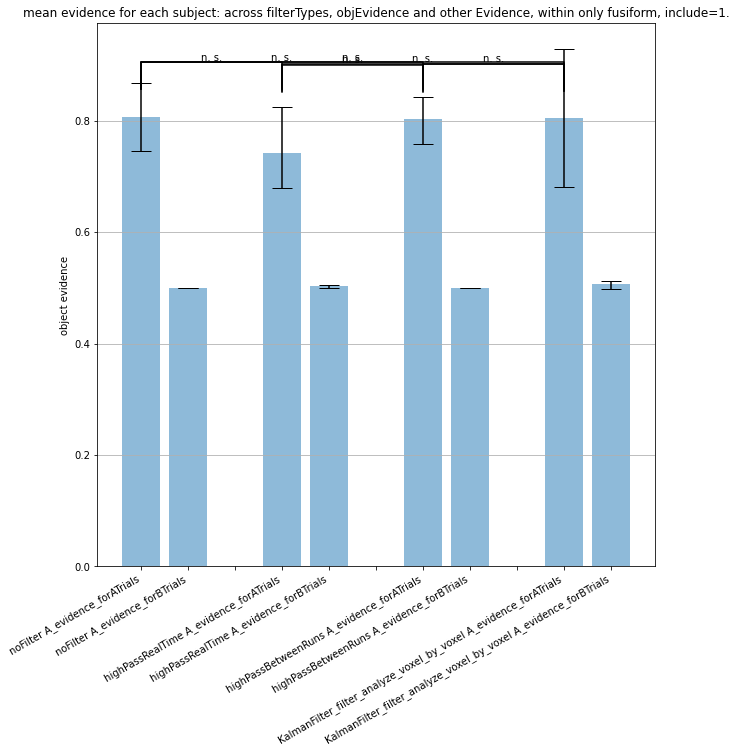

len of a =  [6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6, 0]
noFilter highPassRealTime p=0.8651773127265673
noFilter highPassBetweenRuns p=0.4213008179831088
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.04184814757875965
highPassRealTime highPassBetweenRuns p=0.8050837031688766
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.03767228326873734
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.04098797238764722
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


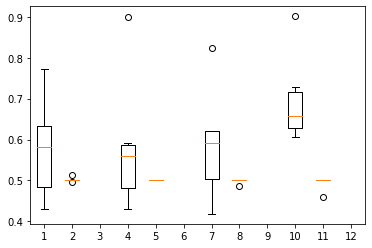

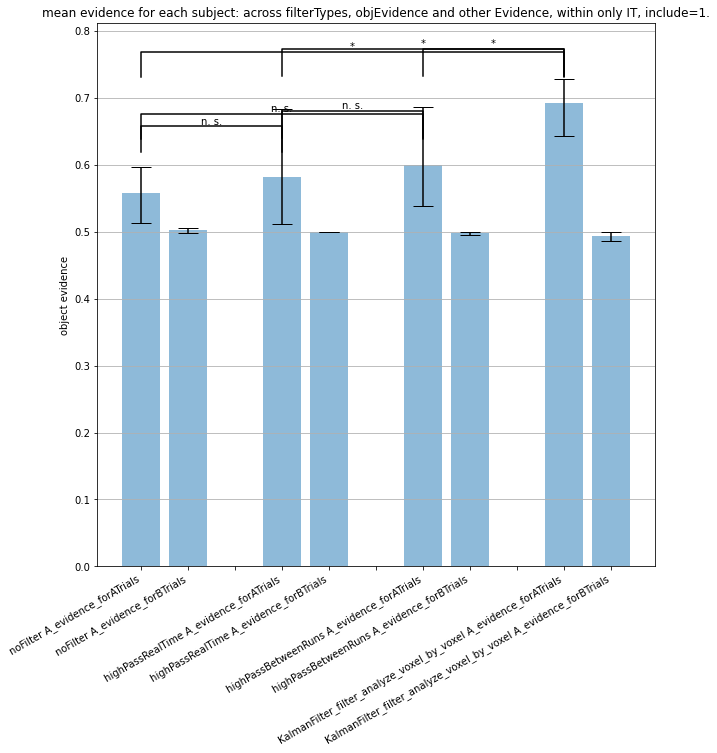

len of a =  [6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6, 0]
noFilter highPassRealTime p=0.07716893052913296
noFilter highPassBetweenRuns p=0.05962145917389137
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.05672337826087486
highPassRealTime highPassBetweenRuns p=0.18760493700853054
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.012573760533625264
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.04722848653387947
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


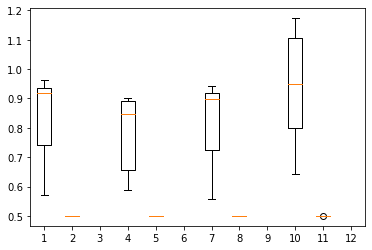

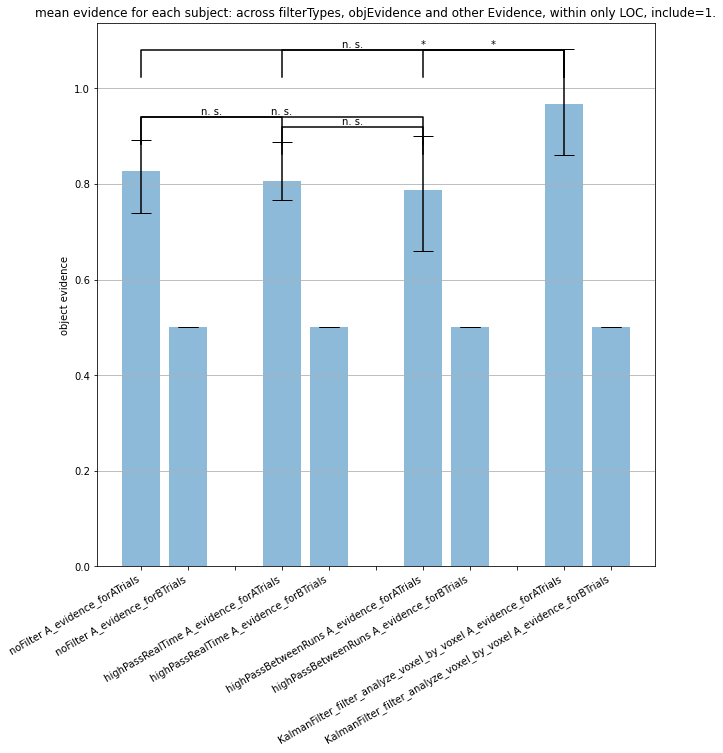

len of a =  [6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6, 0]
noFilter highPassRealTime p=0.009075886779589194
noFilter highPassBetweenRuns p=0.10494143007710369
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.0026792371336060465
highPassRealTime highPassBetweenRuns p=0.006163716536325032
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0032433908042608095
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.0030180952486832872
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


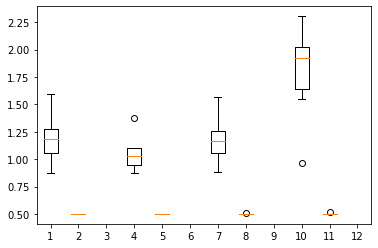

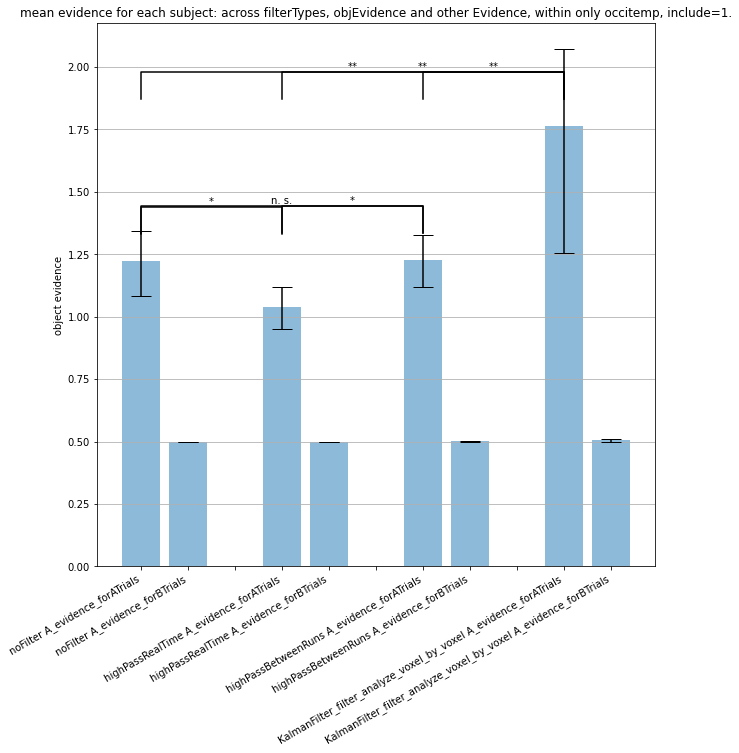

len of a =  [6, 6, 0, 6, 6, 0, 6, 6, 0, 6, 6, 0]
noFilter highPassRealTime p=0.9907718168131827
noFilter highPassBetweenRuns p=0.8186988809874636
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.002080508233088042
highPassRealTime highPassBetweenRuns p=0.8011439719727526
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0020618986036828363
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.00019041935499636238
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)
L.shape= (6,)
L.shape= (6,)
L.shape= (0,)


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


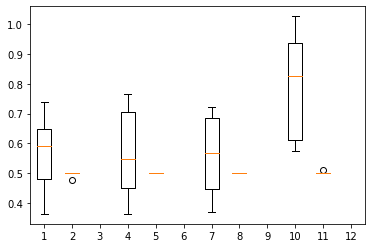

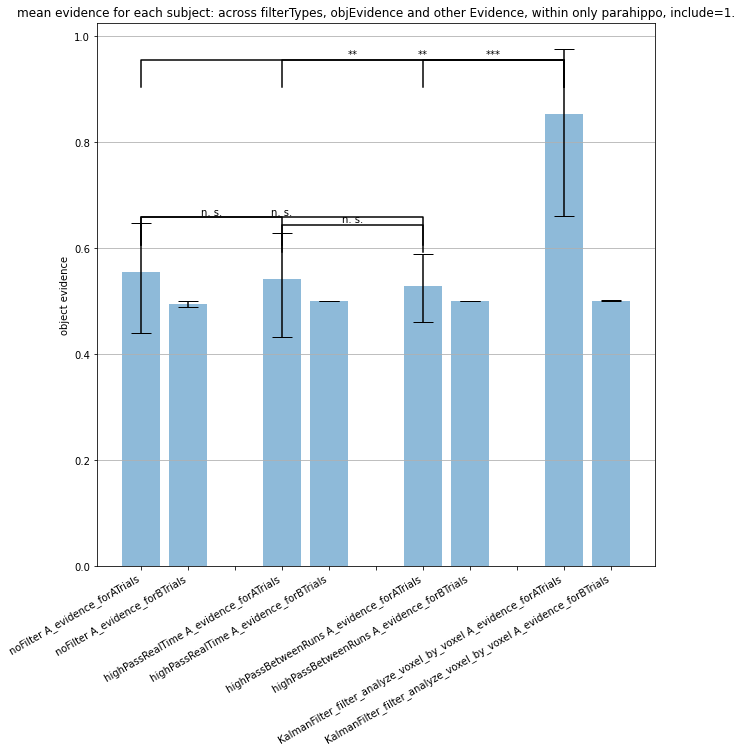

In [53]:


def evidenceAcrossFiltertypes_meanForSub(ROI="V1"):
    # construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is mean value of the 'A_evidence_forATrials for noFilter' for that subject.

    # across filterType, take the difference between objEvidence and other Evidence, within only V1, include=1.
    filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']

    # I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials'])))) #conbine the data together
            d.append(np.nanmean(np.asarray(list(t['A_evidence_forBTrials']))))

        a.append(c)
        a.append(d)
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    print('len of a = ',[len(i) for i in a])
    # bar(a,labels=labels,title=f'evidence: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.')

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # # paired t-test
    # objects=np.arange(4)
    # allpairs = itertools.combinations(objects,2)
    # for pair in allpairs:
    #     i=pair[0]
    #     j=pair[1]
    #     print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")

    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
        pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
        pairs.append((i*3,j*3))

    bar(a,labels=labels,title=f'mean evidence for each subject: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)

for i in range(len(ROIs)):
    evidenceAcrossFiltertypes_meanForSub(ROI=ROIs[i])


100%|██████████| 6/6 [00:00<00:00, 105.12it/s]


noFilter highPassRealTime p=0.016727865250657524
noFilter highPassBetweenRuns p=0.069569968296266
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.009696048802806043
highPassRealTime highPassBetweenRuns p=0.0069421764593900915
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.8304770311068497
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.00028202946525278345
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


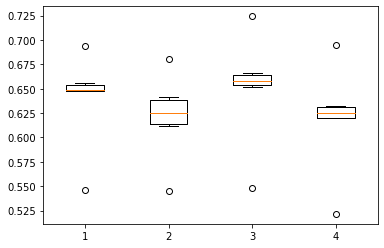

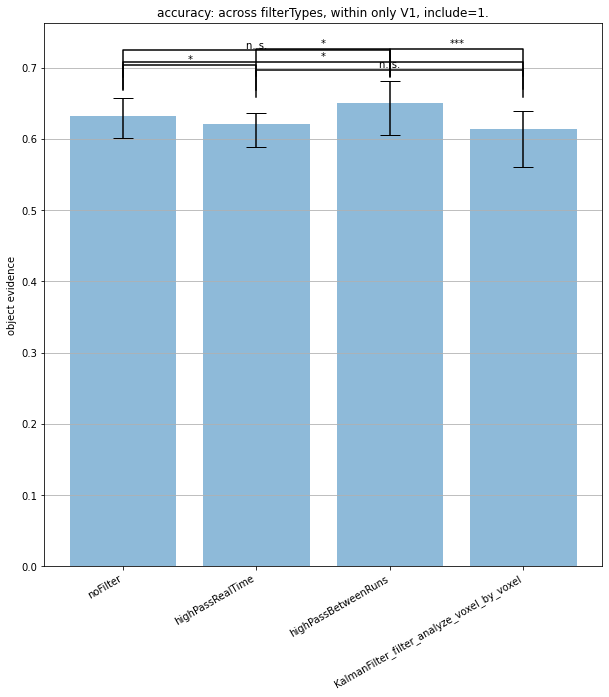

100%|██████████| 6/6 [00:00<00:00, 104.45it/s]


noFilter highPassRealTime p=0.2654874750173405
noFilter highPassBetweenRuns p=0.6468408856783507
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.04817903990144435
highPassRealTime highPassBetweenRuns p=0.21551850997098382
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.14979047534434556
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.046923115488218245
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


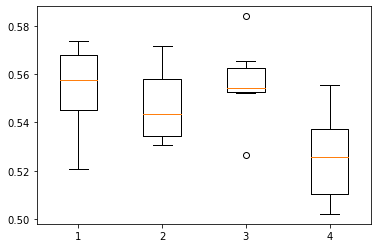

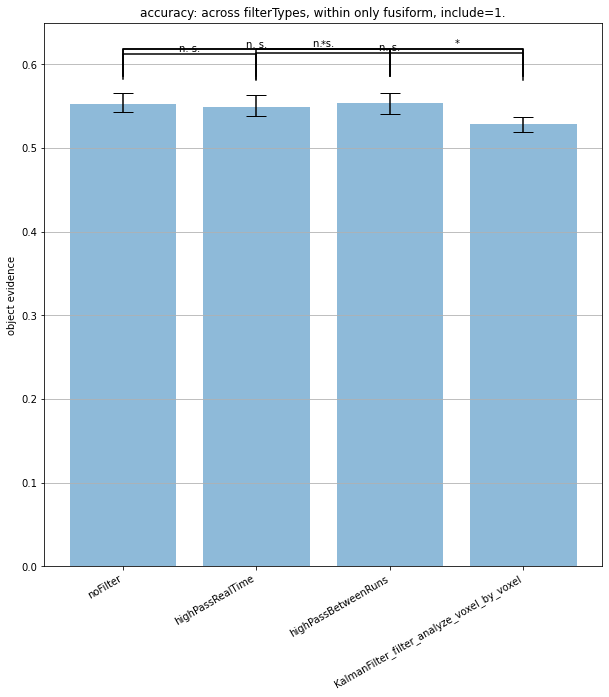

100%|██████████| 6/6 [00:00<00:00, 104.36it/s]


noFilter highPassRealTime p=0.5771752872756586
noFilter highPassBetweenRuns p=0.18202084481210712
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.643852479753799
highPassRealTime highPassBetweenRuns p=0.7470647508267065
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.9041030959886865
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.7453411349736523
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


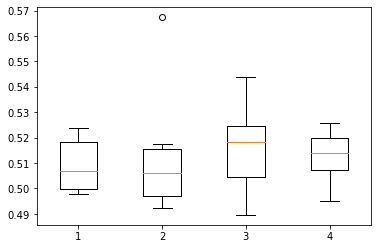

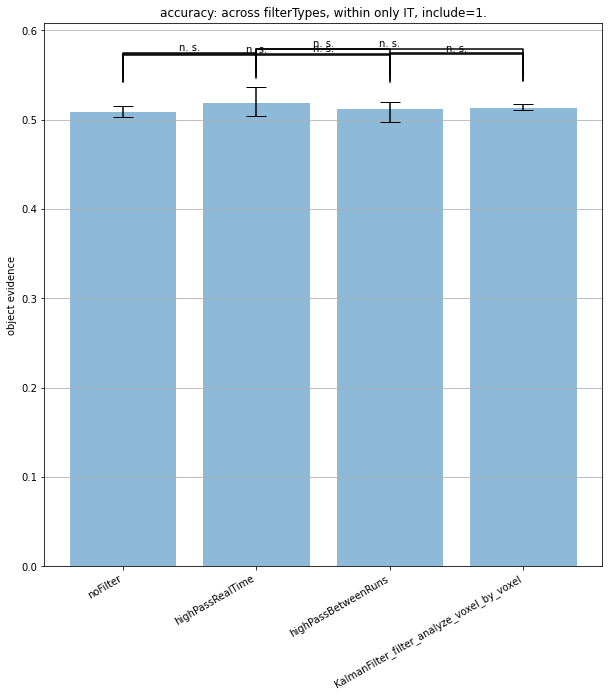

100%|██████████| 6/6 [00:00<00:00, 105.36it/s]


noFilter highPassRealTime p=0.6974517774018894
noFilter highPassBetweenRuns p=0.9043483955332964
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.20469339392585628
highPassRealTime highPassBetweenRuns p=0.6495419499467112
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.37502333095737617
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.20076206182744638
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


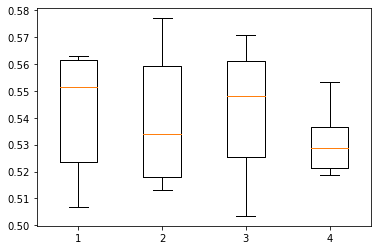

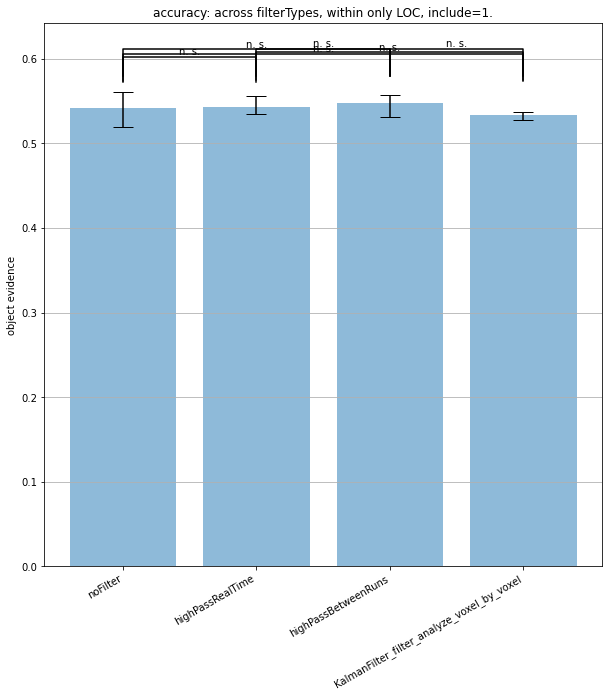

100%|██████████| 6/6 [00:00<00:00, 104.38it/s]


noFilter highPassRealTime p=0.1668177336041552
noFilter highPassBetweenRuns p=0.0359838309729141
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.7081345076115534
highPassRealTime highPassBetweenRuns p=0.0026583796234261638
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.4228674142933023
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.772945929188784
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


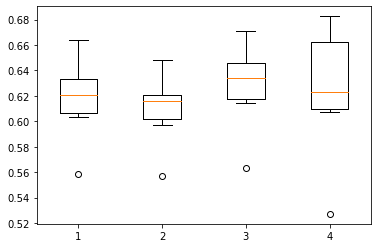

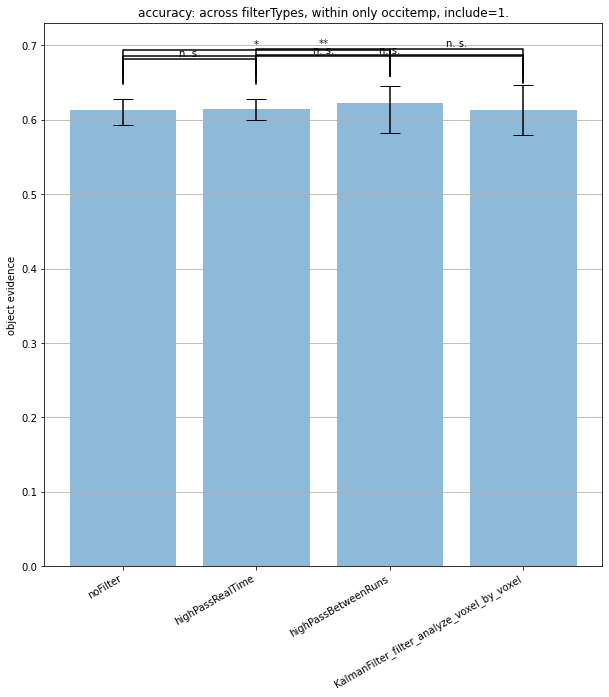

100%|██████████| 6/6 [00:00<00:00, 105.17it/s]


noFilter highPassRealTime p=0.1379341101755902
noFilter highPassBetweenRuns p=0.9420768600492023
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.7508316968105981
highPassRealTime highPassBetweenRuns p=0.08644627722841888
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.251995456081534
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.7980453273598711
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)
L.shape= (6,)


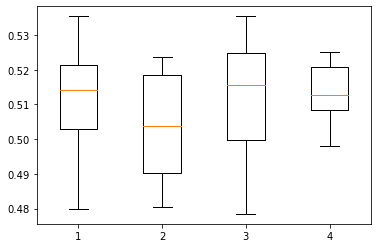

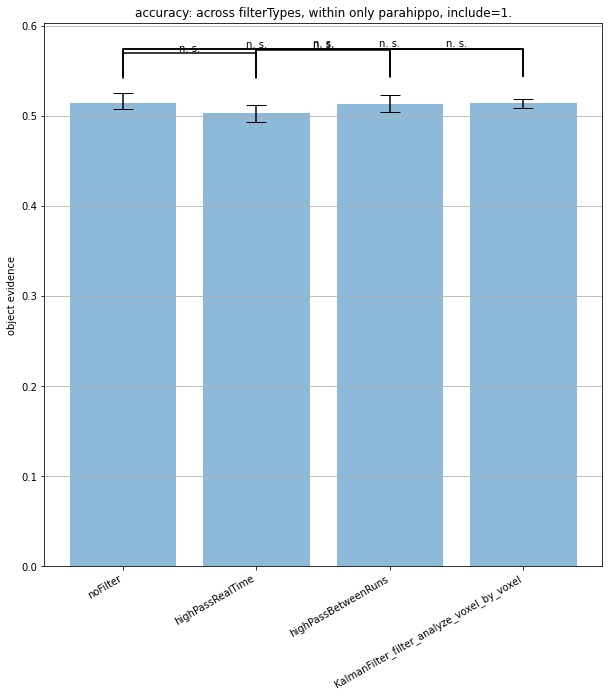

In [56]:
def accuracyAcrossFiltertype(ROI="V1"):
    # accuracy: across filterType, take subject mean, within only V1, include=1.

    # I want to construction a list whose 1st element is the accuracy for noFilter, 2nd for highpass and so on.
    # each element is 32 numbers for 32 subjects. each number is the mean accuracy for that subject.
    a=[]
    for i in range(len(filterTypes)):
        b=[]
        for sub in tqdm(subjects):
            try:
                b.append(np.mean(accuracyContainer[
                        _and_([
                            accuracyContainer['roi']==ROI, 
                            accuracyContainer['filterType']==filterTypes[i],
                            accuracyContainer['sub']==int(sub),
                            accuracyContainer['include']==1.
                        ])]['acc']))
            except:
                pass
        a.append(np.asarray(b))
    # bar(a,labels=list(filterTypes),title=f'accuracy: across filterTypes, within only {ROI}, include=1.')
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # # paired ttest
    # objects=np.arange(4)
    # allpairs = itertools.combinations(objects,2)
    # for pair in allpairs:
    #     i=pair[0]
    #     j=pair[1]
    #     print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i],a[j])[1]}")


    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i],a[j])[1]}")
        pvalue[(i,j)]=stats.ttest_rel(a[i],a[j])[1]
        pairs.append((i,j))
    bar(a,labels=list(filterTypes),title=f'accuracy: across filterTypes, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)
    # bar(a,labels=labels,title=f'mean evidence for each subject: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)

for i in range(len(ROIs)):
    accuracyAcrossFiltertype(ROI=ROIs[i])


(0, 1)
(0, 2)
(0, 3)
(1, 2)
(1, 3)
(2, 3)
